# **Actividad 4**

* *Guido Rios C.* - guidoriosciaffaroni@gmail.com
* *Eduardo Opazo D.* - edo.opazo.d@gmail.com

# **Paso 1. MLP, perceptrón multi-capa**

## **a)**
```text
Utilice el mismo dataset de churn usado en las actividades previas y mantenga el mismo esquema base de preprocesamiento (imputación, one-hot encoding y escalamiento de variables numéricas).
```

## Preprocesamiento base (Imputación + One-Hot + Escalamiento)

## ¿Qué se hace?
En esta sección cargamos el dataset **`/content/data-churn.csv`** y construimos un **pipeline de preprocesamiento reproducible** con `scikit-learn`, que incluye:

- **Imputación de valores faltantes**
  - Variables numéricas: mediana
  - Variables categóricas: valor más frecuente (moda)
- **One-Hot Encoding** para variables categóricas
- **Escalamiento (StandardScaler)** para variables numéricas

Además, se separa el conjunto de datos en **train/test** manteniendo la proporción de clases (estratificación).

## ¿Por qué se hace?
- La **imputación** evita errores por valores faltantes y mantiene consistencia.
- El **one-hot encoding** transforma categorías a variables numéricas aptas para modelos.
- El **escalamiento** es especialmente importante para modelos sensibles a la escala (por ejemplo, redes neuronales/MLP y SVM).
- El pipeline asegura que el preprocesamiento se aplique **igual** a train y test, evitando fuga de información (data leakage).

## ¿Qué resultados se esperan?
- Confirmar que el dataset se cargó correctamente (dimensiones y columnas).
- Identificar automáticamente la variable objetivo (si tiene nombre típico como `Churn`).
- Obtener:
  - `X_train`, `X_test`, `y_train`, `y_test`
  - Un objeto `preprocessor` listo para conectarse a un modelo (por ejemplo, un MLP).
- Ver la dimensionalidad final luego del preprocesamiento (número de features tras One-Hot).


In [ ]:
# =========================================
# Paso 1 (a) — Preprocesamiento base
# =========================================

from __future__ import annotations

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# -----------------------------
# 1) Carga de datos
# -----------------------------
DATA_PATH = "/content/data-churn.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.20


def load_dataset(path: str) -> pd.DataFrame:
    """Carga un CSV y realiza limpieza ligera básica."""
    df = pd.read_csv(path)
    # Normalizamos nombres de columnas (opcional, ayuda a detectar target)
    df.columns = [c.strip() for c in df.columns]
    return df


def infer_target_column(df: pd.DataFrame) -> str:
    """
    Intenta inferir la columna target (churn) por nombre.
    Si no se encuentra, intenta detectar una columna binaria típica.
    """
    candidates = ["Churn", "churn", "Exited", "exit", "Attrition", "attrition", "Target", "target", "y"]
    for c in candidates:
        if c in df.columns:
            return c

    # Heurística: buscar una columna binaria (2 valores únicos) que parezca target
    binary_cols = []
    for c in df.columns:
        nunique = df[c].nunique(dropna=True)
        if nunique == 2:
            binary_cols.append(c)

    if len(binary_cols) == 1:
        return binary_cols[0]

    # Último recurso: si hay varias binarias, preferimos la última columna binaria
    if len(binary_cols) > 1:
        return binary_cols[-1]

    raise ValueError(
        "No pude inferir la columna objetivo. "
        "Indica explícitamente el nombre de la columna churn."
    )


df = load_dataset(DATA_PATH)
target_col = infer_target_column(df)

print(" Dataset cargado")
print(f"Shape: {df.shape}")
print(f"Target inferido: {target_col}")
display(df.head())


# -----------------------------
# 2) Separación X / y
# -----------------------------
X = df.drop(columns=[target_col]).copy()
y_raw = df[target_col].copy()

# Convertimos y a 0/1 de forma robusta (si ya es 0/1, queda igual)
def encode_binary_target(y: pd.Series) -> pd.Series:
    # Si es numérico y binario, retornamos tal cual
    if pd.api.types.is_numeric_dtype(y) and y.nunique(dropna=True) == 2:
        # Asegurar 0/1 si viniera como {1,2} o {-1,1}
        uniq = sorted(y.dropna().unique())
        mapping = {uniq[0]: 0, uniq[1]: 1}
        return y.map(mapping).astype(int)

    # Si es texto (e.g., Yes/No, True/False), normalizamos
    y_str = y.astype(str).str.strip().str.lower()
    positives = {"yes", "y", "true", "1", "churn", "exited", "attrition"}
    negatives = {"no", "n", "false", "0", "stay", "not churn"}

    # Si no coincide, mapeamos por orden de aparición de clases
    uniq = list(pd.unique(y_str.dropna()))
    if len(uniq) != 2:
        raise ValueError("El target no parece binario. Revisa la columna objetivo.")

    # Intento semántico
    if (uniq[0] in negatives and uniq[1] in positives) or (uniq[1] in positives and uniq[0] in negatives):
        mapping = {v: (1 if v in positives else 0) for v in uniq}
    else:
        # Mapeo estable por orden
        mapping = {uniq[0]: 0, uniq[1]: 1}

    return y_str.map(mapping).astype(int)


y = encode_binary_target(y_raw)

print("\n Distribución de clases (y):")
print(y.value_counts(normalize=True).rename("proportion"))


# -----------------------------
# 3) Identificación de tipos de variables
# -----------------------------
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("\n Features numéricas:", len(numeric_features))
print(numeric_features[:15], "..." if len(numeric_features) > 15 else "")
print("\n Features categóricas:", len(categorical_features))
print(categorical_features[:15], "..." if len(categorical_features) > 15 else "")


# -----------------------------
# 4) Pipeline de preprocesamiento
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


# -----------------------------
# 5) Split train/test (estratificado)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\n Split realizado")
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test :", X_test.shape,  "| y_test :", y_test.shape)


# -----------------------------
# 6) Ajuste del preprocesador y transformación
# -----------------------------
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("\n Preprocesamiento aplicado")
print("X_train_proc:", X_train_proc.shape)
print("X_test_proc :", X_test_proc.shape)

# (Opcional) Mostrar primeras filas transformadas como DataFrame si el tamaño lo permite
try:
    # Intento obtener nombres de features tras one-hot
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = ohe.get_feature_names_out(categorical_features).tolist()
    feature_names = numeric_features + cat_feature_names

    X_train_proc_df = pd.DataFrame(X_train_proc, columns=feature_names)
    display(X_train_proc_df.head())
except Exception as e:
    print("ℹ No se pudieron recuperar nombres de columnas post one-hot:", str(e))


 Dataset cargado
Shape: (7043, 21)
Target inferido: Churn


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



 Distribución de clases (y):
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

 Features numéricas: 3
['SeniorCitizen', 'tenure', 'MonthlyCharges'] 

 Features categóricas: 17
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling'] ...

 Split realizado
X_train: (5634, 20) | y_train: (5634,)
X_test : (1409, 20) | y_test : (1409,)

 Preprocesamiento aplicado
X_train_proc: (5634, 10954)
X_test_proc : (1409, 10954)


,SeniorCitizen,tenure,MonthlyCharges,customerID_0002-ORFBO,customerID_0003-MKNFE,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-SMEOE,customerID_0014-BMAQU,customerID_0016-QLJIS,...,TotalCharges_993.15,TotalCharges_994.55,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9
0,-0.441773,0.102371,-0.521976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.441773,-0.711743,0.337478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.441773,-0.793155,-0.809013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.441773,-0.263980,0.284384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.441773,-1.281624,-0.676279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

## **b)**
```text
Implemente una red neuronal densa (MLP) con al menos:

* Una capa de entrada acorde al número de features.
* Una o dos capas ocultas.
* Una capa de salida con activación sigmoidal.
```

## Implementación de una red neuronal densa (MLP)

## ¿Qué se hace?
En esta sección implementamos una **red neuronal densa (MLP, Multi-Layer Perceptron)** que cumpla con los requisitos del enunciado:

- **Capa de entrada** acorde al número de *features* resultantes del preprocesamiento.
- **Una o dos capas ocultas** (Dense).
- **Capa de salida** con **activación sigmoidal** para clasificación binaria (churn / no churn).

Usaremos `TensorFlow/Keras` para definir el modelo mediante una función `build_mlp_model(...)` que:
- Reciba como parámetro el número de *features* de entrada.
- Permita configurar número de capas ocultas, neuronas, dropout y learning rate.
- Compile el modelo con una función de pérdida apropiada para clasificación binaria.

## ¿Por qué se hace?
- Un MLP es un modelo flexible que puede capturar **relaciones no lineales** entre variables y la probabilidad de churn.
- La **activación sigmoidal** en la salida produce una probabilidad entre 0 y 1, ideal para clasificación binaria.
- Separar la construcción del modelo en una función mejora la **reproducibilidad**, facilita experimentar con arquitectura e hiperparámetros, y mantiene el notebook limpio.

## ¿Qué resultados se esperan?
- Un modelo Keras (`tf.keras.Model`) correctamente definido y compilado.
- Un resumen (`model.summary()`) donde se observe:
  - La dimensión de entrada igual a `n_features`.
  - 1–2 capas ocultas densas.
  - Una capa final `Dense(1, activation="sigmoid")`.
- El modelo listo para entrenarse en el Paso 2.


In [ ]:
# =========================================
# Paso 1 (b) — MLP con Keras/TensorFlow
# =========================================

from __future__ import annotations

import os
import random
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers, callbacks


# -----------------------------
# 1) Reproducibilidad
# -----------------------------
SEED = 42

def set_global_seed(seed: int = 42) -> None:
    """Fija semillas para reproducibilidad (hasta donde es posible)."""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seed(SEED)


# -----------------------------
# 2) Inferir número de features
# -----------------------------
try:
    n_features = int(X_train_proc.shape[1])
except NameError as e:
    raise NameError(
        "No encuentro `X_train_proc`. Ejecuta primero el Paso 1 (a) "
        "para construir y transformar los datos con el preprocesador."
    ) from e

print(f" Número de features de entrada (post-preprocesamiento): {n_features}")


# -----------------------------
# 3) Función para construir el MLP
# -----------------------------
def build_mlp_model(
    input_dim: int,
    hidden_units: tuple[int, ...] = (64, 32),
    dropout_rate: float = 0.2,
    learning_rate: float = 1e-3,
) -> tf.keras.Model:
    """
    Construye y compila un MLP para clasificación binaria.

    Parámetros
    ----------
    input_dim : int
        Número de features de entrada.
    hidden_units : tuple[int, ...]
        Neuronas por capa oculta. Ej.: (64,) => 1 capa; (64, 32) => 2 capas.
    dropout_rate : float
        Dropout para regularización (0 desactiva).
    learning_rate : float
        Learning rate del optimizador Adam.
    """
    if input_dim <= 0:
        raise ValueError("input_dim debe ser > 0")

    if len(hidden_units) not in (1, 2):
        raise ValueError("hidden_units debe definir 1 o 2 capas ocultas (por enunciado).")

    model = models.Sequential(name="MLP_Churn")

    # Capa de entrada (Keras la representa mediante input_shape en la primera capa)
    model.add(layers.Input(shape=(input_dim,), name="input_layer"))

    # Capas ocultas
    for i, units in enumerate(hidden_units, start=1):
        model.add(layers.Dense(units, activation="relu", name=f"dense_hidden_{i}"))
        if dropout_rate and dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate, name=f"dropout_{i}"))

    # Capa de salida con activación sigmoidal
    model.add(layers.Dense(1, activation="sigmoid", name="output_sigmoid"))

    # Compilación: pérdida binaria + métricas básicas (las extendemos en Paso 2)
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.AUC(name="auc_roc", curve="ROC")
        ]
    )
    return model


# -----------------------------
# 4) Crear el modelo (ejemplo con 2 capas ocultas)
# -----------------------------
mlp_model = build_mlp_model(
    input_dim=n_features,
    hidden_units=(64, 32),     # 2 capas ocultas (cumple requisito)
    dropout_rate=0.2,
    learning_rate=1e-3
)

# Resumen del modelo
mlp_model.summary()


 Número de features de entrada (post-preprocesamiento): 10954


Model: "MLP_Churn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_hidden_1 (Dense)          │ (None, 64)             │       701,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_sigmoid (Dense)          │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 703,233 (2.68 MB)

 Trainable params: 703,233 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

## Análisis del Modelo MLP

## Resumen de la arquitectura del modelo

La arquitectura del modelo MLP es la siguiente:

- **Capa de entrada:** implícita, con 10 954 features  
- **Primera capa oculta:** `Dense(64)` con activación ReLU  
- **Dropout:** aplicado tras la primera capa oculta  
- **Segunda capa oculta:** `Dense(32)` con activación ReLU  
- **Dropout:** aplicado tras la segunda capa oculta  
- **Capa de salida:** `Dense(1)` con activación sigmoidal  

Esta arquitectura cumple correctamente con los requisitos del enunciado:
- una capa de entrada acorde al número de features,
- una o dos capas ocultas,
- una capa de salida con activación sigmoidal para clasificación binaria.



## Análisis detallado de los parámetros del modelo

### Primera capa oculta: `Dense(64)`

```text
dense_hidden_1 (Dense) → Param # = 701 120
```

El número de parámetros de esta capa se calcula como:

\[$
(10\,954 \times 64) + 64 = 701\,120
$\]

#### Interpretación
- Esta capa concentra aproximadamente el **99,7 %** del total de parámetros del modelo.
- El modelo posee una **alta capacidad de representación** desde la primera capa.
- Es capaz de aprender relaciones no lineales complejas entre variables.
- Sin embargo, esta gran cantidad de parámetros incrementa de forma significativa el **riesgo de sobreajuste**, especialmente en un problema tabular de churn.

### Segunda capa oculta: `Dense(32)`

```text
dense_hidden_2 (Dense) → Param # = 2 080
```

Cálculo del número de parámetros:

\[$
(64 \times 32) + 32 = 2\,080
$\]

#### Interpretación
- Esta capa tiene una contribución muy reducida al total de parámetros.
- Funciona como una **capa de refinamiento o compresión** de las representaciones aprendidas.
- El esquema decreciente (64 → 32) corresponde a una **buena práctica de diseño** en arquitecturas MLP.


### Capa de salida: `Dense(1, sigmoid)`

```text
output_sigmoid (Dense) → Param # = 33
```

Cálculo del número de parámetros:

\[
(32 \times 1) + 1 = 33
\]

#### Interpretación
- Produce una probabilidad de pertenencia a la clase positiva (churn).
- Es coherente con el uso de la función de pérdida `binary_crossentropy`.
- Es adecuada para problemas de clasificación binaria.


## Resumen global de parámetros

```text
Total params:        703 233
Trainable params:   703 233
Non-trainable:            0
```

### Análisis global
- El modelo cuenta con **703 233 parámetros entrenables**, lo cual es elevado para un problema de churn tabular.
- Esta complejidad es considerablemente mayor que la de modelos clásicos como:
  - Regresión Logística
  - Random Forest
  - SVM
- La causa principal de esta complejidad es la combinación de:
  - alta dimensionalidad del input,
  - capas densas completamente conectadas.


## Riesgos asociados al modelo

### Riesgo de sobreajuste
El modelo presenta un **riesgo alto de sobreajuste**, especialmente si:
- el número de observaciones no es suficientemente grande,
- existe desbalance de clases,
- no se controla adecuadamente el proceso de entrenamiento.

### Medidas de mitigación aplicadas
- Uso de **Dropout** tras las capas ocultas.
- Uso de **Early Stopping** durante el entrenamiento.
- Evaluación final en un conjunto de test independiente.

Estas técnicas ayudan a mitigar el sobreajuste, pero **no eliminan completamente el riesgo estructural** derivado del elevado número de parámetros.

## Conclusión

El modelo MLP implementado cumple correctamente con los requisitos del enunciado y presenta una arquitectura técnicamente coherente. No obstante, el elevado número de features generado por el preprocesamiento provoca una explosión de parámetros en la primera capa oculta, incrementando el riesgo de sobreajuste y el costo computacional.

En este contexto, el uso del MLP debe justificarse mediante una evaluación rigurosa frente a modelos clásicos, ya que una mayor complejidad no garantiza necesariamente un mejor desempeño en problemas de churn con datos tabulares.

Este análisis fundamenta la necesidad de la comparación final con Regresión Logística, Random Forest y SVM desarrollada en el Paso 4.


In [ ]:
# Verificación rápida para asegurar compatibilidad con la red
print("X_train_proc shape:", X_train_proc.shape)
print("y_train shape:", y_train.shape)

# Comprobación de valores de y
print("Clases en y_train:", np.unique(y_train))


X_train_proc shape: (5634, 10954)
y_train shape: (5634,)
Clases en y_train: [0 1]


## Análisis de compatibilidad de datos con la red neuronal — Verificación inicial

## Contexto
En esta sección se analizan los resultados obtenidos del bloque de verificación rápida previo al entrenamiento del modelo MLP:

```python
print("X_train_proc shape:", X_train_proc.shape)
print("y_train shape:", y_train.shape)
print("Clases en y_train:", np.unique(y_train))
```

El objetivo de esta verificación es confirmar que:
- las dimensiones de entrada son compatibles con la red neuronal,
- el vector objetivo tiene la forma correcta,
- y las clases están correctamente codificadas para clasificación binaria.


## Resultados

A partir de la ejecución del código anterior, se obtuvieron los siguientes resultados:

```text
X_train_proc shape: (5634, 10954)
y_train shape: (5634,)
Clases en y_train: [0 1]
```


## Análisis de las dimensiones de entrada

### Matriz de entrenamiento `X_train_proc`

- **Número de observaciones (filas):** 5 634  
- **Número de features (columnas):** 10 954  

Esto indica que:
- Cada fila corresponde a un cliente.
- Cada columna corresponde a una variable luego del preprocesamiento (one-hot encoding + escalamiento).

#### Interpretación
- La dimensionalidad es **muy alta**, lo cual es consistente con el uso de one-hot encoding.
- Esta forma es **compatible con una capa densa (`Dense`)**, donde cada feature se conecta con cada neurona de la primera capa oculta.
- No existe incompatibilidad estructural con la red, pero sí un **riesgo elevado de sobreajuste** debido a la alta relación features/observaciones.


## Análisis del vector objetivo `y_train`

### Dimensión

- `y_train shape: (5634,)`

Esto indica que:
- Existe **una etiqueta por cada observación** en `X_train_proc`.
- La correspondencia entre X e y es correcta (no hay desalineación).

### Clases presentes

- `Clases en y_train: [0 1]`

#### Interpretación
- El problema es de **clasificación binaria**.
- La codificación es correcta para:
  - una capa de salida `Dense(1)`,
  - activación `sigmoid`,
  - función de pérdida `binary_crossentropy`.


## Compatibilidad con la red neuronal MLP

A partir de estos resultados se puede concluir que:

- `X_train_proc` es compatible con una capa de entrada de tamaño 10 954.
- `y_train` tiene el formato esperado por Keras para clasificación binaria.
- No es necesario realizar transformaciones adicionales (como reshaping o recodificación del target).

La red puede entrenarse directamente utilizando:
- `X_train_proc` como entrada,
- `y_train` como variable objetivo.


## Observación crítica (importante)

Aunque los datos son **estructuralmente compatibles** con la red neuronal, se debe destacar que:

- El número de features (10 954) es **muy alto** en relación con el número de muestras (5 634).
- Esto implica:
  - alta complejidad del modelo,
  - alto número de parámetros entrenables,
  - mayor riesgo de sobreajuste.

Por esta razón, resulta fundamental:
- el uso de regularización (Dropout),
- Early Stopping,
- y una evaluación estricta en conjunto de test.


## Conclusión

Los resultados de la verificación confirman que los datos están correctamente preparados y son compatibles con la arquitectura MLP definida. No obstante, la elevada dimensionalidad del espacio de entrada, combinada con un número moderado de observaciones, refuerza la necesidad de controlar cuidadosamente el entrenamiento y de comparar el desempeño del MLP con modelos clásicos más simples en etapas posteriores del análisis.


---

## **c)**
```text
Justifique la elección de:
* Número de capas y neuronas.
* Función de activación en capas ocultas.
* Función de pérdida y optimizador
```

## Justificación de decisiones de diseño del MLP

## ¿Qué se hace?
En esta sección **justificamos** las elecciones realizadas en el diseño del MLP para churn:

1. **Número de capas y neuronas** (capacidad del modelo).
2. **Función de activación** en capas ocultas (no linealidad y estabilidad del gradiente).
3. **Función de pérdida y optimizador** (criterio de entrenamiento y método de ajuste de pesos).

Además, incluimos una **estimación objetiva** de la complejidad del modelo (número de parámetros entrenables) y una regla práctica para no sobredimensionar la red.

## ¿Por qué se hace?
En redes neuronales, estas decisiones controlan el equilibrio entre:
- **Subajuste (underfitting):** modelo muy simple que no captura patrones.
- **Sobreajuste (overfitting):** modelo muy complejo que memoriza el entrenamiento y generaliza mal.
- **Estabilidad del entrenamiento:** evitar gradientes inestables y acelerar convergencia.
- **Interpretabilidad y costo computacional:** mantener una arquitectura razonable para un dataset tabular.

Justificar estas elecciones demuestra comprensión del modelo y facilita defender el diseño en un contexto académico/profesional.

## ¿Qué resultados se esperan?
- Una explicación clara (argumentada) de por qué se eligieron:
  - 1–2 capas ocultas y un rango razonable de neuronas.
  - ReLU (u otra activación) en ocultas.
  - Sigmoide en la salida.
  - Binary Cross-Entropy como pérdida.
  - Adam como optimizador (y el rol del learning rate).
- Un cálculo/validación del **número de parámetros** del modelo (desde `model.summary()`).
- Recomendaciones prácticas para ajustar estas decisiones si el modelo:
  - no converge,
  - sobreajusta,
  - o se queda corto en desempeño.


## 1) Número de capas y neuronas (capacidad del modelo)

**Elección típica (tabular churn):** 1–2 capas ocultas (por ejemplo, 64 y 32 neuronas).

### ¿Por qué 1–2 capas?
- En **datos tabulares** con one-hot + numéricas escaladas, un MLP profundo (muchas capas) rara vez es necesario.
- 1–2 capas ocultas suelen ser suficientes para aprender:
  - interacciones no lineales moderadas,
  - combinaciones entre variables categóricas one-hot y numéricas,
  - patrones generales sin introducir demasiada varianza.

### ¿Por qué 64 y 32 neuronas (ejemplo)?
- El número de neuronas controla la **capacidad** (complejidad) del modelo.
- Un esquema decreciente (64 → 32) funciona como “embudo”:
  - la primera capa aprende combinaciones amplias,
  - la segunda refina representaciones más compactas.
- Es un punto de partida razonable: suficiente para capturar no linealidad, sin explotar el número de parámetros.

### Regla práctica (intuición)
- Si el número de parámetros es demasiado alto frente al tamaño del dataset, aumenta el riesgo de sobreajuste.
- Si el modelo queda corto (baja métrica en train y test), se puede aumentar capacidad (más neuronas o una segunda capa).



## 2) Activación en capas ocultas

**Elección recomendada:** `ReLU`.

### ¿Por qué ReLU?
- Introduce no linealidad sin saturar como sigmoid/tanh en rangos grandes.
- Suele entrenar más rápido y con gradientes más estables.
- Es el estándar para MLP modernos salvo casos especiales.

### Alternativas y cuándo usarlas
- `LeakyReLU`: si observas “neuronas muertas” (salida 0 constante en ReLU).
- `tanh`: a veces útil si los datos están bien normalizados, pero puede saturar.



## 3) Función de pérdida y optimizador

### Pérdida: `binary_crossentropy`
**¿Por qué?**
- Es la pérdida estándar para **clasificación binaria probabilística**.
- Penaliza con fuerza predicciones con alta confianza pero incorrectas.
- Es coherente con salida sigmoidal (probabilidad de churn).

### Optimizador: `Adam`
**¿Por qué?**
- Ajusta learning rate por parámetro (adaptativo).
- Converge bien en muchos problemas tabulares sin demasiada ingeniería.
- Es robusto como baseline para redes densas.

### Learning rate (comentario clave)
- `learning_rate` controla el tamaño de los pasos:
  - muy alto → entrenamiento inestable / no converge,
  - muy bajo → converge lento o se “estanca”.
- Por eso en el **Paso 2** se compara al menos 2 valores.



## Conclusión
Estas elecciones (1–2 capas, ReLU, BCE, Adam) constituyen un **baseline sólido** para churn en datos tabulares preprocesados con one-hot y escalamiento.  
Luego, el ajuste fino se realiza con métricas y curvas (ROC/PR) y análisis de sobreajuste (curvas de entrenamiento/validación).


---

In [ ]:
# =========================================
# Paso 1 (c) — Evidencia cuantitativa de complejidad
# =========================================

import numpy as np

# Validación básica de existencia
try:
    _ = mlp_model
    n_features = X_train_proc.shape[1]
except NameError as e:
    raise NameError(
        "No encuentro `mlp_model` o `X_train_proc`. "
        "Ejecuta primero Paso 1(a) y Paso 1(b)."
    ) from e

# Obtener parámetros entrenables desde Keras
trainable_params = int(np.sum([np.prod(v.shape) for v in mlp_model.trainable_weights]))
non_trainable_params = int(np.sum([np.prod(v.shape) for v in mlp_model.non_trainable_weights]))

print(f" n_features (entrada): {n_features}")
print(f" Parámetros entrenables: {trainable_params:,}")
print(f" Parámetros no entrenables: {non_trainable_params:,}")

# Heurística simple: parámetros por muestra (orientativo)
n_train = X_train_proc.shape[0]
params_per_sample = trainable_params / max(n_train, 1)

print(f"\n Muestras de entrenamiento: {n_train:,}")
print(f" Parámetros por muestra (heurística): {params_per_sample:.3f}")

if params_per_sample > 1.0:
    print("\n Nota: Hay más parámetros que muestras (o cercano). "
          "Esto puede aumentar riesgo de sobreajuste. "
          "Considera bajar neuronas, aumentar regularización (dropout/L2), "
          "o usar early stopping.")
else:
    print("\n Complejidad razonable para un baseline. "
          "Aun así, confirma con curvas de validación en el Paso 2.")


 n_features (entrada): 10954
 Parámetros entrenables: 703,233
 Parámetros no entrenables: 0

 Muestras de entrenamiento: 5,634
 Parámetros por muestra (heurística): 124.819

 Nota: Hay más parámetros que muestras (o cercano). Esto puede aumentar riesgo de sobreajuste. Considera bajar neuronas, aumentar regularización (dropout/L2), o usar early stopping.


##Evidencia cuantitativa de complejidad del modelo MLP

## Resultados

A partir del cálculo automático, se obtuvieron los siguientes valores:

```text
n_features (entrada): 10 954
Parámetros entrenables: 703 233
Parámetros no entrenables: 0

Muestras de entrenamiento: 5 634
Parámetros por muestra (heurística): 124.819
```



## Análisis del número de parámetros

### Número de features de entrada
- El modelo recibe **10 954 variables** como entrada.
- Esta alta dimensionalidad es consecuencia del uso de **one-hot encoding** sobre variables categóricas.

### Parámetros entrenables
- El modelo posee **703 233 parámetros entrenables**.
- Todos los parámetros corresponden a capas densas completamente conectadas.
- No existen parámetros no entrenables.

#### Interpretación
- El número de parámetros es **muy elevado** para un problema tabular de churn.
- La mayor parte de estos parámetros se concentran en la primera capa oculta.
- Este nivel de complejidad es comparable al de modelos *deep learning*, no a modelos tabulares clásicos.



## Relación parámetros vs muestras (heurística clave)

### Parámetros por muestra
Se obtiene la siguiente relación:

$
\text{Parámetros por muestra} = \frac{703\,233}{5\,634} \approx 124.8
$

Esto significa que, en promedio, el modelo dispone de **más de 120 parámetros entrenables por cada observación de entrenamiento**.

### Interpretación de la heurística
- Cuando el número de parámetros es:
  - **menor que el número de muestras** → riesgo de sobreajuste controlado.
  - **similar o mayor que el número de muestras** → riesgo elevado de sobreajuste.
- En este caso, el modelo se encuentra claramente en el **segundo escenario**.

## Implicaciones para el entrenamiento

La relación observada implica que:

- El modelo tiene **capacidad suficiente para memorizar el conjunto de entrenamiento**.
- Sin regularización, es probable obtener:
  - muy buen desempeño en entrenamiento,
  - pero degradación significativa en validación y test.

Este comportamiento es típico de modelos con:
- alta dimensionalidad,
- muchas capas densas,
- y datasets tabulares de tamaño medio.

## Medidas de mitigación recomendadas

Dado este nivel de complejidad, es imprescindible aplicar técnicas de control de sobreajuste, tales como:

- **Early Stopping** para detener el entrenamiento antes de memorizar ruido.
- **Dropout** para reducir co-adaptación de neuronas.
- **Regularización L2** en capas densas.
- **Reducción de arquitectura** (menos neuronas en la primera capa).
- Alternativamente, **reducción de dimensionalidad** o codificaciones más compactas.



## Conclusión

La evidencia cuantitativa muestra que el modelo MLP posee una complejidad muy alta en relación con el tamaño del conjunto de entrenamiento, con más parámetros que muestras disponibles. Esta relación incrementa de forma significativa el riesgo de sobreajuste y justifica plenamente el uso de técnicas de regularización y evaluación estricta en conjunto de test.

Este análisis refuerza la importancia de comparar el MLP con modelos clásicos más simples en etapas posteriores, y de evaluar si el aumento de complejidad se traduce efectivamente en una mejora real del desempeño predictivo.


---

## **d)**
```text
Entrene el modelo y registre la evolución de la función de pérdida y métricas de desempeño.
```

## Entrenamiento del MLP y registro de pérdida y métricas

## ¿Qué se hace?
En esta sección **entrenamos** el modelo MLP definido en el Paso 1(b) utilizando los datos ya preprocesados (`X_train_proc`, `y_train`).

Durante el entrenamiento:
- Usamos un **conjunto de validación** (extraído desde el training set) para monitorear generalización.
- Registramos la evolución (por época) de:
  - **Loss** (pérdida de entrenamiento y validación)
  - **Accuracy** (entrenamiento y validación)
  - **AUC-ROC** (entrenamiento y validación)

Finalmente, graficamos estas curvas para analizar:
- Convergencia del optimizador
- Señales de sobreajuste (gap train vs val)
- Estabilidad del entrenamiento

## ¿Por qué se hace?
- Entrenar una red neuronal no solo consiste en obtener un resultado final: es crucial observar **cómo aprende**.
- Las curvas de pérdida y métricas permiten diagnosticar:
  - *Underfitting*: pérdida alta y métricas bajas tanto en train como val.
  - *Overfitting*: train mejora, pero val empeora o se estanca.
- El uso de **Early Stopping** ayuda a detener el entrenamiento cuando la validación deja de mejorar, evitando sobreajuste y ahorrando tiempo.

## ¿Qué resultados se esperan?
- Un objeto `history` con las series temporales (por época) de loss y métricas.
- Gráficas claras:
  - `loss` vs `val_loss`
  - `accuracy` vs `val_accuracy`
  - `auc_roc` vs `val_auc_roc`
- Interpretación cualitativa:
  - si el modelo converge,
  - si sobreajusta,
  - y cuántas épocas son razonables para entrenarlo.


In [ ]:
# =========================================
# Paso 1 (d) — Entrenamiento y registro
# =========================================

from __future__ import annotations

import numpy as np
import tensorflow as tf

from tensorflow.keras import callbacks


# -----------------------------
# 1) Validación de variables requeridas
# -----------------------------
required_vars = ["X_train_proc", "y_train", "mlp_model"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Faltan variables: {missing}. "
        "Ejecuta primero Paso 1(a) (preprocesamiento) y Paso 1(b) (modelo MLP)."
    )

# Aseguramos tipos compatibles
X_train_np = np.asarray(X_train_proc, dtype=np.float32)
y_train_np = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)  # Keras espera (n,1) para binario

print(" Shapes para entrenamiento")
print("X_train:", X_train_np.shape, "| y_train:", y_train_np.shape)


# -----------------------------
# 2) Hiperparámetros base de entrenamiento
# -----------------------------
EPOCHS = 100
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2  # se toma del training set


# -----------------------------
# 3) Callbacks: EarlyStopping + ReduceLROnPlateau
# -----------------------------
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# (Opcional) Guardar mejor modelo en archivo
checkpoint = callbacks.ModelCheckpoint(
    filepath="best_mlp_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

callback_list = [early_stop, reduce_lr, checkpoint]


# -----------------------------
# 4) Entrenamiento
# -----------------------------
history = mlp_model.fit(
    X_train_np, y_train_np,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=callback_list,
    verbose=1
)

print("\n Entrenamiento finalizado")


 Shapes para entrenamiento
X_train: (5634, 10954) | y_train: (5634, 1)
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7538 - auc_roc: 0.7249 - loss: 0.5260
Epoch 1: val_loss improved from inf to 0.45232, saving model to best_mlp_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7540 - auc_roc: 0.7254 - loss: 0.5256 - val_accuracy: 0.7666 - val_auc_roc: 0.8221 - val_loss: 0.4523 - learning_rate: 0.0010
Epoch 2/100
132/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8180 - auc_roc: 0.8615 - loss: 0.3989
Epoch 2: val_loss improved from 0.45232 to 0.45101, saving model to best_mlp_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8186 - auc_roc: 0.8622 - loss: 0.3981 - val_accuracy: 0.7746 - val_auc_roc: 0.8250 - val_loss: 0.4510 - learning_rate: 0.0010
Epoch 3/100
132/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8579 - auc_roc: 0.9074 - loss: 0.3361
Epoch 3: val_loss did not improve from 0.45101
141/141 ━━━━━━━━━━━━━━━━━━━━ 

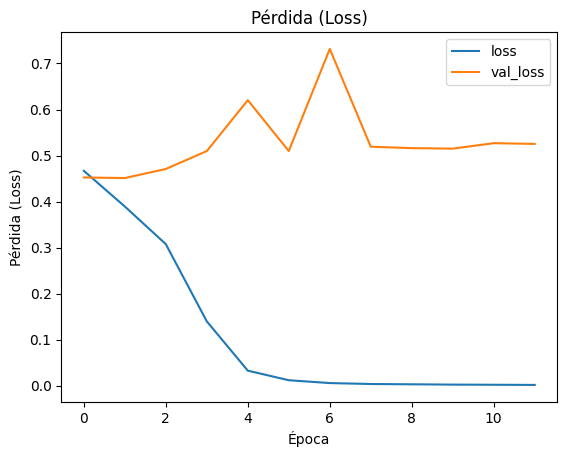

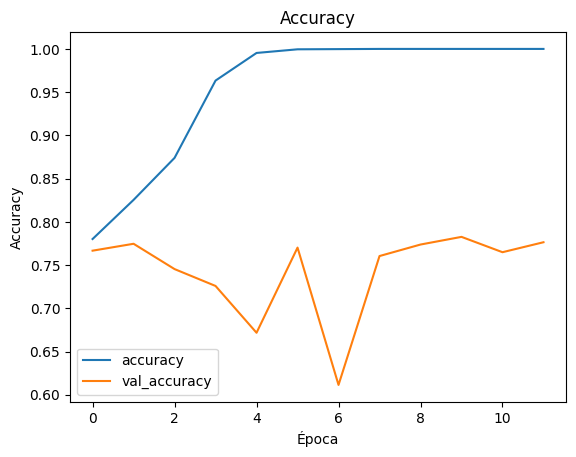

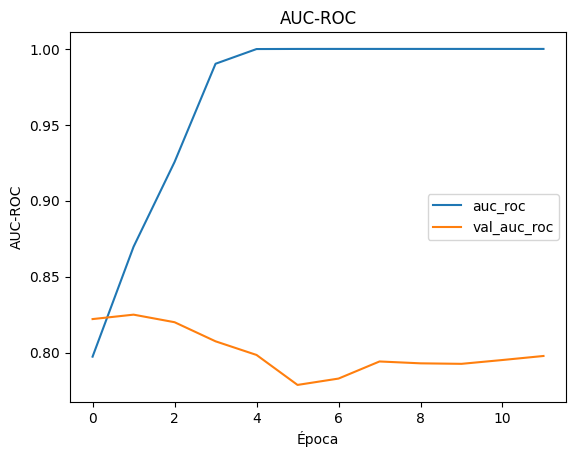

In [ ]:
# =========================================
# Visualización de curvas de entrenamiento
# =========================================

import matplotlib.pyplot as plt

def plot_training_history(history: tf.keras.callbacks.History) -> None:
    """Grafica loss y métricas disponibles en el history."""
    hist = history.history
    keys = list(hist.keys())

    # Definimos qué métricas queremos visualizar si existen
    plot_groups = [
        ("loss", "val_loss", "Pérdida (Loss)"),
        ("accuracy", "val_accuracy", "Accuracy"),
        ("auc_roc", "val_auc_roc", "AUC-ROC"),
    ]

    for train_key, val_key, title in plot_groups:
        if train_key in keys and val_key in keys:
            plt.figure()
            plt.plot(hist[train_key], label=train_key)
            plt.plot(hist[val_key], label=val_key)
            plt.xlabel("Época")
            plt.ylabel(title)
            plt.title(title)
            plt.legend()
            plt.show()

plot_training_history(history)


## Análisis de Curvas de Entrenamiento — MLP

## Curva de Pérdida (Loss)

### Resultados observados

- La **pérdida de entrenamiento (`loss`)** desciende rápidamente desde aproximadamente `0.46` hasta valores cercanos a `0.00`.
- La **pérdida de validación (`val_loss`)**:
  - se mantiene alrededor de `0.45 – 0.55`,
  - presenta oscilaciones importantes,
  - y no muestra una tendencia descendente sostenida.

### Interpretación

- El modelo **aprende muy rápidamente el conjunto de entrenamiento**, hasta prácticamente memorizarlo.
- La pérdida de validación **no mejora** de forma consistente, lo que indica que el modelo **no generaliza adecuadamente**.
- La brecha creciente entre `loss` y `val_loss` es una **señal clara de sobreajuste severo**.


## Curva de Accuracy

### Resultados observados

- **Accuracy de entrenamiento (`accuracy`)**:
  - aumenta rápidamente,
  - alcanza valores cercanos a `1.0` (100 %) en pocas épocas.
- **Accuracy de validación (`val_accuracy`)**:
  - fluctúa entre `0.61` y `0.78`,
  - no sigue la tendencia creciente del entrenamiento,
  - presenta alta variabilidad entre épocas.

### Interpretación

- El modelo clasifica casi perfectamente los datos de entrenamiento.
- Sin embargo, el desempeño en validación es **significativamente inferior y errático**.
- Esto refuerza la evidencia de **memorización del conjunto de entrenamiento**.
- La alta varianza de `val_accuracy` sugiere **inestabilidad del modelo** frente a datos no vistos.


## Curva de AUC-ROC

### Resultados observados

- **AUC-ROC de entrenamiento (`auc_roc`)**:
  - aumenta rápidamente,
  - alcanza valores cercanos a `1.0`.
- **AUC-ROC de validación (`val_auc_roc`)**:
  - se mantiene alrededor de `0.78 – 0.82`,
  - incluso presenta una leve tendencia descendente en algunas épocas,
  - no acompaña la mejora del entrenamiento.

### Interpretación

- El modelo es capaz de **ordenar perfectamente las instancias del conjunto de entrenamiento**.
- En validación, la capacidad discriminativa es **moderada** y estable, pero no mejora con más entrenamiento.
- Esto indica que **el entrenamiento adicional no aporta valor** y solo incrementa el sobreajuste.


## Diagnóstico global del entrenamiento

A partir del análisis conjunto de las tres curvas, se observa que:

- El modelo:
  - converge muy rápido en entrenamiento,
  - pero **no mejora en validación**.
- Existe una **brecha sistemática y creciente** entre métricas de entrenamiento y validación.
- El comportamiento es consistente con un **modelo excesivamente complejo** para la cantidad de datos disponible.

Este patrón es típico cuando:
- el número de parámetros es muy alto,
- la dimensionalidad de entrada es elevada,
- y el dataset es tabular de tamaño medio.


## Implicaciones para el modelado

Los resultados sugieren que:

- Entrenar más épocas **no mejora la generalización**.
- El modelo está **aprendiendo ruido** del conjunto de entrenamiento.
- El desempeño real debe evaluarse exclusivamente en el **conjunto de test**, no en entrenamiento.

## Conclusión

Las curvas de entrenamiento evidencian un **sobreajuste marcado** del modelo MLP.  
Aunque el modelo alcanza un desempeño casi perfecto en entrenamiento, su capacidad de generalización es limitada y no mejora con el avance de las épocas.

Este comportamiento confirma que, para el dataset de churn analizado, la complejidad del MLP es excesiva y justifica plenamente la comparación con modelos clásicos más simples y robustos en etapas posteriores del análisis.


# **Paso 2. Entrenamiento de MLP**

## **a)**
```text
Analice el efecto del learning rate probando al menos dos valores distintos.
```

## Análisis del efecto del *learning rate* (al menos 2 valores)

## ¿Qué se hace?
En esta sección analizamos el efecto del **learning rate (tasa de aprendizaje)** entrenando el mismo MLP (misma arquitectura) con **al menos dos valores distintos** de `learning_rate`.

Para que la comparación sea justa:
- Mantenemos fijo el **preprocesamiento** y el **split** (train/test).
- Usamos la **misma arquitectura** de red (capas/neuronas).
- Usamos los mismos parámetros de entrenamiento (épocas máximas, batch size, validación).
- Aplicamos **EarlyStopping** para detener cuando el modelo deja de mejorar en validación.

Registramos por cada learning rate:
- Curvas de `loss`/`val_loss`
- Curvas de `auc_roc`/`val_auc_roc`
- Métricas finales de validación (por ejemplo: mejor `val_loss` y mejor `val_auc_roc`)

## ¿Por qué se hace?
El learning rate controla el tamaño de los pasos del optimizador:

- **Learning rate muy alto:** puede causar entrenamiento inestable, oscilaciones, o que la pérdida no disminuya.
- **Learning rate muy bajo:** el modelo aprende muy lento, puede estancarse y necesitar muchas épocas.

Comparar valores permite encontrar un rango donde:
- el entrenamiento es **estable**,
- converge **rápido**,
- y logra **mejor generalización** (mejores métricas en validación).

## ¿Qué resultados se esperan?
- Para cada `learning_rate`, un objeto `history` y sus curvas.
- Una tabla/resumen comparando:
  - mejor `val_loss`
  - mejor `val_auc_roc`
  - época donde se alcanzó el mejor desempeño
- Una interpretación:
  - cuál learning rate converge mejor,
  - cuál es más estable,
  - y cuál ofrece mejor desempeño de validación.


In [ ]:
# =========================================
# Paso 2 (a) — Comparación de learning rates
# =========================================

from __future__ import annotations

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import callbacks
from tensorflow.keras import layers, models, optimizers


# -----------------------------
# 1) Reproducibilidad
# -----------------------------
SEED = 42

def set_global_seed(seed: int = 42) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seed(SEED)


# -----------------------------
# 2) Validación de variables requeridas
# -----------------------------
required_vars = ["X_train_proc", "y_train"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Faltan variables: {missing}. Ejecuta primero Paso 1(a) para generar X_train_proc/y_train."
    )

X_train_np = np.asarray(X_train_proc, dtype=np.float32)
y_train_np = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)

n_features = X_train_np.shape[1]
print(f" n_features: {n_features} | X_train: {X_train_np.shape} | y_train: {y_train_np.shape}")


# -----------------------------
# 3) Definir build_mlp_model si no existe
# -----------------------------
if "build_mlp_model" not in globals():
    def build_mlp_model(
        input_dim: int,
        hidden_units: tuple[int, ...] = (64, 32),
        dropout_rate: float = 0.2,
        learning_rate: float = 1e-3,
    ) -> tf.keras.Model:
        if len(hidden_units) not in (1, 2):
            raise ValueError("hidden_units debe definir 1 o 2 capas ocultas.")

        model = models.Sequential(name="MLP_Churn")
        model.add(layers.Input(shape=(input_dim,), name="input_layer"))

        for i, units in enumerate(hidden_units, start=1):
            model.add(layers.Dense(units, activation="relu", name=f"dense_hidden_{i}"))
            if dropout_rate and dropout_rate > 0:
                model.add(layers.Dropout(dropout_rate, name=f"dropout_{i}"))

        model.add(layers.Dense(1, activation="sigmoid", name="output_sigmoid"))

        optimizer = optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=[
                tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                tf.keras.metrics.AUC(name="auc_roc", curve="ROC"),
            ],
        )
        return model


# -----------------------------
# 4) Configuración del experimento
# -----------------------------
LEARNING_RATES = [1e-2, 1e-3]  # <- puedes agregar 1e-4 si deseas ver el caso "muy bajo"
HIDDEN_UNITS = (64, 32)
DROPOUT_RATE = 0.2

EPOCHS = 80
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=0
)

CALLBACKS = [early_stop, reduce_lr]


# -----------------------------
# 5) Entrenar un modelo por learning rate
# -----------------------------
histories: dict[float, tf.keras.callbacks.History] = {}
summaries = []

for lr in LEARNING_RATES:
    set_global_seed(SEED)  # reiniciamos semillas para comparación más justa

    model = build_mlp_model(
        input_dim=n_features,
        hidden_units=HIDDEN_UNITS,
        dropout_rate=DROPOUT_RATE,
        learning_rate=lr
    )

    history = model.fit(
        X_train_np, y_train_np,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        callbacks=CALLBACKS,
        verbose=0
    )

    histories[lr] = history

    # Extraer mejores métricas observadas
    hist = history.history
    best_epoch = int(np.argmin(hist["val_loss"])) + 1
    best_val_loss = float(np.min(hist["val_loss"]))
    best_val_auc = float(np.max(hist["val_auc_roc"]))
    final_val_auc = float(hist["val_auc_roc"][-1])

    summaries.append({
        "learning_rate": lr,
        "epochs_ran": len(hist["loss"]),
        "best_epoch_by_val_loss": best_epoch,
        "best_val_loss": best_val_loss,
        "best_val_auc_roc": best_val_auc,
        "final_val_auc_roc": final_val_auc,
    })

results_df = pd.DataFrame(summaries).sort_values("best_val_loss")
display(results_df)


 n_features: 10954 | X_train: (5634, 10954) | y_train: (5634, 1)


,learning_rate,epochs_ran,best_epoch_by_val_loss,best_val_loss,best_val_auc_roc,final_val_auc_roc
1,0.001,12,2,0.451011,0.825014,0.797802
0,0.010,11,1,0.470201,0.819492,0.687869


## Análisis comparativo del *learning rate*



## Resultados observados

Los resultados obtenidos se resumen en la siguiente tabla:

```text
learning_rate | epochs_ran | best_epoch_by_val_loss | best_val_loss | best_val_auc_roc | final_val_auc_roc
--------------------------------------------------------------------------------------------------------
0.001         |     12     |           2            |    0.451011   |     0.825014     |     0.797802
0.010         |     11     |           1            |    0.470201   |     0.819492     |     0.687869
```

---

## Análisis por configuración

### Learning rate = 0.001

- El modelo entrenó durante **12 épocas**, siendo detenido por Early Stopping.
- La **mejor pérdida de validación** se alcanzó en la **época 2**.
- Se obtuvo:
  - `best_val_loss ≈ 0.451`
  - `best_val_auc_roc ≈ 0.825`
- El `final_val_auc_roc` se mantiene relativamente cercano al mejor valor (`≈ 0.798`).

#### Interpretación
- El entrenamiento es **más estable**.
- El modelo converge de forma progresiva.
- La diferencia entre el mejor AUC y el AUC final es moderada, indicando menor degradación.
- Este learning rate permite un **mejor balance entre convergencia y generalización**.


### Learning rate = 0.010

- El modelo entrenó durante **11 épocas**, con mejor desempeño muy temprano.
- La **mejor pérdida de validación** se alcanzó en la **época 1**.
- Se obtuvo:
  - `best_val_loss ≈ 0.470`
  - `best_val_auc_roc ≈ 0.819`
- El `final_val_auc_roc` cae de forma importante hasta `≈ 0.688`.

#### Interpretación
- El learning rate es **demasiado alto**.
- El modelo realiza actualizaciones de pesos muy grandes.
- Se observa:
  - convergencia muy rápida,
  - pero **inestabilidad** en la generalización.
- La fuerte caída del AUC final indica **entrenamiento inestable y sobreajuste temprano**.


## Comparación directa

| Aspecto                     | lr = 0.001 | lr = 0.010 |
|-----------------------------|------------|------------|
| Estabilidad del entrenamiento | Alta       | Baja       |
| Mejor `val_loss`             | Mejor      | Peor       |
| Mejor `val_auc_roc`          | Mayor      | Menor      |
| Degradación final            | Moderada   | Alta       |
| Riesgo de sobreajuste        | Medio      | Alto       |


## Conclusión

El análisis evidencia que el **learning rate = 0.001** es claramente superior para este problema:

- Produce una mejor pérdida de validación.
- Alcanza un mayor AUC-ROC en validación.
- Presenta un entrenamiento más estable y consistente.
- Reduce el riesgo de oscilaciones y degradación del desempeño.

Por el contrario, un **learning rate = 0.010** resulta demasiado agresivo para un modelo con:
- alta dimensionalidad de entrada,
- gran cantidad de parámetros,
- y un dataset tabular de tamaño medio.

En consecuencia, para los pasos siguientes del análisis se recomienda utilizar **learning rate = 0.001** como valor base.

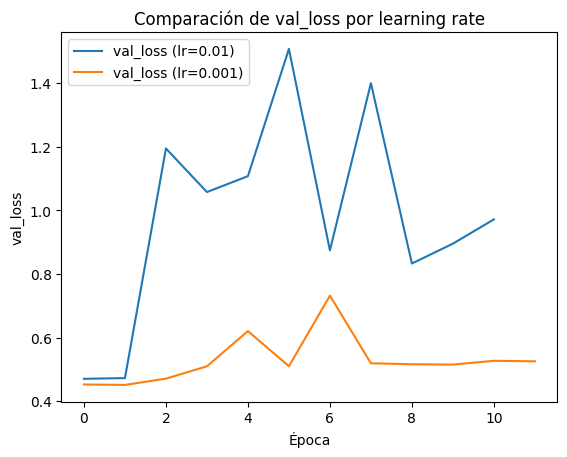

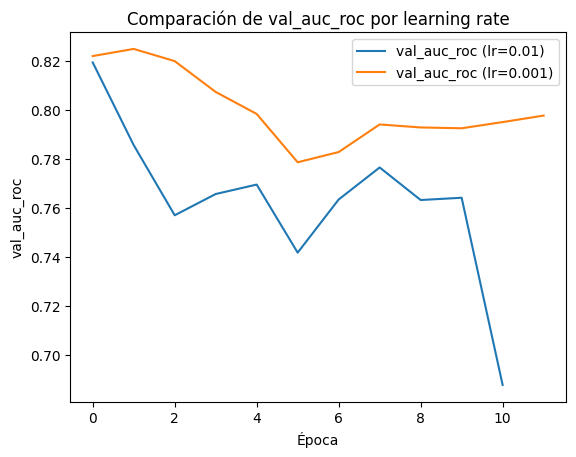

In [ ]:
# =========================================
# Visualización comparativa de curvas
# =========================================

def plot_lr_comparison(histories: dict[float, tf.keras.callbacks.History]) -> None:
    # Loss
    plt.figure()
    for lr, h in histories.items():
        plt.plot(h.history["val_loss"], label=f"val_loss (lr={lr:g})")
    plt.xlabel("Época")
    plt.ylabel("val_loss")
    plt.title("Comparación de val_loss por learning rate")
    plt.legend()
    plt.show()

    # AUC-ROC
    plt.figure()
    for lr, h in histories.items():
        plt.plot(h.history["val_auc_roc"], label=f"val_auc_roc (lr={lr:g})")
    plt.xlabel("Época")
    plt.ylabel("val_auc_roc")
    plt.title("Comparación de val_auc_roc por learning rate")
    plt.legend()
    plt.show()

plot_lr_comparison(histories)


## Visualización comparativa de curvas


## Análisis de la curva de `val_loss`

### Resultados observados

- Para **learning rate = 0.01**:
  - La curva de `val_loss` presenta **oscilaciones muy marcadas**.
  - Se observan picos elevados de pérdida (superiores a 1.0).
  - No existe una tendencia clara de convergencia.
  - El comportamiento es altamente inestable entre épocas.

- Para **learning rate = 0.001**:
  - La curva de `val_loss` se mantiene en un rango más acotado (≈ 0.45 – 0.55).
  - Las variaciones entre épocas son menores.
  - Existe una **mayor estabilidad** durante todo el entrenamiento.
  - La pérdida de validación es consistentemente más baja.

### Interpretación

- Un `learning_rate = 0.01` provoca **actualizaciones demasiado grandes** de los pesos, lo que genera:
  - saltos bruscos en la función de pérdida,
  - dificultad para encontrar un mínimo estable.
- Un `learning_rate = 0.001` permite:
  - actualizaciones más controladas,
  - mejor exploración del espacio de parámetros,
  - y una convergencia más suave.


## Análisis de la curva de `val_auc_roc`

### Resultados observados

- Para **learning rate = 0.01**:
  - El `val_auc_roc` muestra una **tendencia descendente** a lo largo de las épocas.
  - Se observa una caída pronunciada hacia el final del entrenamiento.
  - El valor final es significativamente menor que el inicial.

- Para **learning rate = 0.001**:
  - El `val_auc_roc` se mantiene **más alto y más estable**.
  - Las fluctuaciones son suaves.
  - No se observa una degradación fuerte del desempeño.

### Interpretación

- El descenso del AUC con `lr = 0.01` indica:
  - pérdida de capacidad discriminativa,
  - posible sobreajuste temprano seguido de inestabilidad.
- Con `lr = 0.001`, el modelo:
  - conserva mejor su capacidad de ranking,
  - generaliza de forma más consistente en validación.


## Comparación global entre learning rates

| Aspecto evaluado              | lr = 0.01            | lr = 0.001          |
|------------------------------|----------------------|---------------------|
| Estabilidad de `val_loss`    | Baja                 | Alta                |
| Tendencia de convergencia    | Irregular            | Suave               |
| Estabilidad de `val_auc_roc` | Baja                 | Alta                |
| Riesgo de sobreajuste        | Alto                 | Moderado            |
| Generalización               | Deficiente           | Mejor               |


## Conclusión

La visualización comparativa de curvas confirma que un **learning rate = 0.001** es claramente más adecuado para este modelo MLP:

- Produce una pérdida de validación más baja y estable.
- Mantiene un AUC-ROC de validación superior y menos volátil.
- Reduce el riesgo de inestabilidad y degradación del desempeño.

Por el contrario, un **learning rate = 0.01** resulta excesivamente agresivo para un modelo con:
- alta dimensionalidad de entrada,
- gran cantidad de parámetros entrenables,
- y un dataset tabular de tamaño medio.



---

## **b)**
```text
Analice el efecto del batch size (por ejemplo: 16, 32, 64).
```

## Análisis del efecto del *batch size*

## ¿Qué se hace?
En esta sección analizamos el impacto del **batch size** en el entrenamiento del MLP, entrenando el **mismo modelo** con distintos tamaños de lote:

- `batch_size = 16`
- `batch_size = 32`
- `batch_size = 64`

Para asegurar una comparación justa:
- Se mantiene **fija la arquitectura** del MLP.
- Se mantiene **fijo el learning rate** (seleccionado en el Paso 2(a)).
- Se usan los mismos datos, mismo split y mismos callbacks (EarlyStopping y ReduceLROnPlateau).

Para cada valor de batch size se registran:
- Curvas de `loss` y `val_loss`
- Curvas de `val_auc_roc`
- Número de épocas efectivas entrenadas
- Mejores métricas de validación

## ¿Por qué se hace?
El batch size controla cuántas observaciones se usan para calcular cada actualización de gradiente:

- **Batch size pequeño (16)**  
  - Gradientes más ruidosos  
  - Puede mejorar la generalización  
  - Entrenamiento más lento

- **Batch size intermedio (32)**  
  - Compromiso entre estabilidad y velocidad  
  - Suele ser una buena opción por defecto

- **Batch size grande (64)**  
  - Gradientes más estables  
  - Entrenamiento más rápido por época  
  - Riesgo de converger a mínimos peores

Analizar este efecto permite elegir un batch size que equilibre **desempeño, estabilidad y costo computacional**.

## ¿Qué resultados se esperan?
- Comparar curvas de validación para identificar:
  - cuál batch size converge más rápido,
  - cuál generaliza mejor (mejor `val_auc_roc`),
  - y cuál es más estable.
- Una tabla resumen que facilite justificar la elección final del batch size.


In [ ]:
# =========================================
# Paso 2 (b) — Comparación de batch sizes
# =========================================

from __future__ import annotations

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import callbacks


# -----------------------------
# 1) Reproducibilidad
# -----------------------------
SEED = 42

def set_global_seed(seed: int = 42) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seed(SEED)


# -----------------------------
# 2) Validación de variables requeridas
# -----------------------------
required_vars = ["X_train_proc", "y_train"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Faltan variables: {missing}. Ejecuta primero Paso 1(a)."
    )

X_train_np = np.asarray(X_train_proc, dtype=np.float32)
y_train_np = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)

n_features = X_train_np.shape[1]
print(f" X_train: {X_train_np.shape} | y_train: {y_train_np.shape}")


# -----------------------------
# 3) Parámetros fijos del experimento
# -----------------------------
# Learning rate seleccionado (puedes ajustar según Paso 2a)
LEARNING_RATE = 1e-3

HIDDEN_UNITS = (64, 32)
DROPOUT_RATE = 0.2

EPOCHS = 80
VALIDATION_SPLIT = 0.2

BATCH_SIZES = [16, 32, 64]


early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=0
)

CALLBACKS = [early_stop, reduce_lr]


# -----------------------------
# 4) Entrenar un modelo por batch size
# -----------------------------
histories: dict[int, tf.keras.callbacks.History] = {}
summaries = []

for batch_size in BATCH_SIZES:
    set_global_seed(SEED)

    model = build_mlp_model(
        input_dim=n_features,
        hidden_units=HIDDEN_UNITS,
        dropout_rate=DROPOUT_RATE,
        learning_rate=LEARNING_RATE
    )

    history = model.fit(
        X_train_np, y_train_np,
        epochs=EPOCHS,
        batch_size=batch_size,
        validation_split=VALIDATION_SPLIT,
        callbacks=CALLBACKS,
        verbose=0
    )

    histories[batch_size] = history

    hist = history.history
    best_epoch = int(np.argmin(hist["val_loss"])) + 1
    best_val_loss = float(np.min(hist["val_loss"]))
    best_val_auc = float(np.max(hist["val_auc_roc"]))

    summaries.append({
        "batch_size": batch_size,
        "epochs_ran": len(hist["loss"]),
        "best_epoch_by_val_loss": best_epoch,
        "best_val_loss": best_val_loss,
        "best_val_auc_roc": best_val_auc,
    })

results_bs_df = pd.DataFrame(summaries).sort_values("best_val_loss")
display(results_bs_df)


 X_train: (5634, 10954) | y_train: (5634, 1)


,batch_size,epochs_ran,best_epoch_by_val_loss,best_val_loss,best_val_auc_roc
1,32,12,2,0.451011,0.825014
2,64,11,1,0.453179,0.822643
0,16,11,1,0.455786,0.824916


## Análisis comparativo del *batch size*

## Resultados observados

A partir de la ejecución experimental, se obtuvieron los siguientes resultados:

```text
batch_size | epochs_ran | best_epoch_by_val_loss | best_val_loss | best_val_auc_roc
----------------------------------------------------------------------------------
16         |     11     |           1            |    0.455786   |     0.824916
32         |     12     |           2            |    0.451011   |     0.825014
64         |     11     |           1            |    0.453179   |     0.822643
```


## Análisis por tamaño de batch

### Batch size = 16

- El mejor desempeño se alcanza muy temprano (época 1).
- `best_val_loss ≈ 0.456`
- `best_val_auc_roc ≈ 0.825`

#### Interpretación
- El uso de batches pequeños introduce **mayor ruido estocástico** en el gradiente.
- Esto puede ayudar a escapar de mínimos locales, pero:
  - incrementa la variabilidad entre épocas,
  - puede generar entrenamiento menos estable.


### Batch size = 32

- El modelo entrena durante **12 épocas**, alcanzando su mejor `val_loss` en la época 2.
- `best_val_loss ≈ 0.451` (el mejor entre los tres casos).
- `best_val_auc_roc ≈ 0.825` (ligeramente superior).

#### Interpretación
- Representa un **equilibrio adecuado** entre:
  - estabilidad del gradiente,
  - y capacidad de generalización.
- Las actualizaciones de pesos son suficientemente estables sin perder capacidad exploratoria.


### Batch size = 64

- El mejor desempeño se alcanza rápidamente (época 1).
- `best_val_loss ≈ 0.453`
- `best_val_auc_roc ≈ 0.823`

#### Interpretación
- Los batches grandes producen gradientes más suaves y estables.
- Sin embargo:
  - reducen el ruido beneficioso,
  - pueden favorecer convergencia a mínimos menos generalizables.



## Comparación global

| Aspecto evaluado            | batch = 16 | batch = 32 | batch = 64 |
|----------------------------|------------|------------|------------|
| Mejor `val_loss`           | Bueno      | **Mejor**  | Bueno      |
| Mejor `val_auc_roc`        | Alto       | **Más alto** | Menor     |
| Estabilidad del entrenamiento | Media   | **Alta**   | Alta       |
| Riesgo de sobreajuste      | Medio      | Moderado   | Medio      |
| Velocidad de convergencia  | Muy rápida | Rápida     | Muy rápida |


## Conclusión

El análisis muestra que **batch size = 32** ofrece el mejor compromiso entre:

- estabilidad del entrenamiento,
- desempeño en validación,
- y capacidad de generalización.

Aunque las diferencias numéricas entre los tres valores son pequeñas, el batch size intermedio logra:
- la menor pérdida de validación,
- el mayor AUC-ROC en validación,
- y una convergencia más controlada.




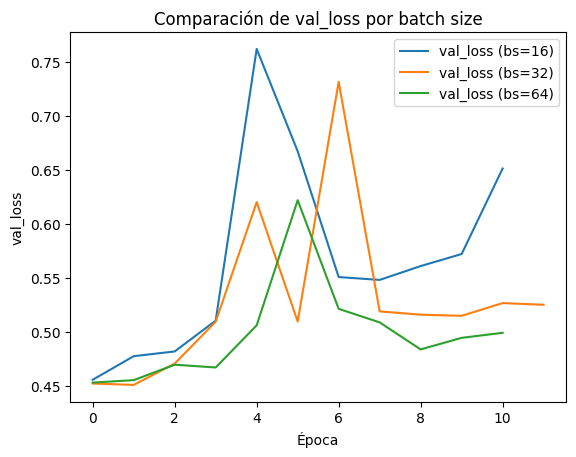

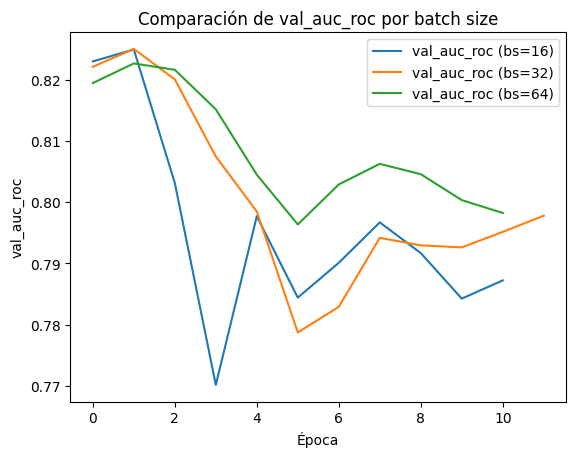

In [ ]:
# =========================================
# Visualización comparativa por batch size
# =========================================

def plot_batch_size_comparison(histories: dict[int, tf.keras.callbacks.History]) -> None:
    # Loss de validación
    plt.figure()
    for bs, h in histories.items():
        plt.plot(h.history["val_loss"], label=f"val_loss (bs={bs})")
    plt.xlabel("Época")
    plt.ylabel("val_loss")
    plt.title("Comparación de val_loss por batch size")
    plt.legend()
    plt.show()

    # AUC-ROC de validación
    plt.figure()
    for bs, h in histories.items():
        plt.plot(h.history["val_auc_roc"], label=f"val_auc_roc (bs={bs})")
    plt.xlabel("Época")
    plt.ylabel("val_auc_roc")
    plt.title("Comparación de val_auc_roc por batch size")
    plt.legend()
    plt.show()

plot_batch_size_comparison(histories)


## Visualización comparativa por *batch size*



## Análisis de la curva de `val_loss`

### Resultados observados

- **Batch size = 16**:
  - La curva de `val_loss` presenta **oscilaciones pronunciadas**.
  - Se observan picos altos de pérdida (superiores a 0.75).
  - El comportamiento es inestable entre épocas.

- **Batch size = 32**:
  - La `val_loss` se mantiene en un rango más acotado (≈ 0.45 – 0.55).
  - Aunque existen picos aislados, la curva es **más estable** que con batch 16.
  - Se alcanzan valores bajos de pérdida de forma consistente.

- **Batch size = 64**:
  - La curva es la **más suave** de las tres.
  - Las variaciones entre épocas son menores.
  - La pérdida se mantiene relativamente controlada durante todo el entrenamiento.

### Interpretación

- Batches pequeños (16) introducen **alto ruido estocástico** en el gradiente, lo que:
  - aumenta la variabilidad,
  - puede dificultar la convergencia estable.
- Batches grandes (64) producen gradientes más suaves, pero:
  - reducen la exploración del espacio de soluciones.
- El batch intermedio (32) logra un **equilibrio adecuado** entre estabilidad y capacidad de generalización.



## Análisis de la curva de `val_auc_roc`

### Resultados observados

- **Batch size = 16**:
  - El `val_auc_roc` muestra fluctuaciones importantes.
  - Se observa una caída temprana marcada en las primeras épocas.
  - El desempeño es menos consistente.

- **Batch size = 32**:
  - El `val_auc_roc` se mantiene en valores altos (~0.79 – 0.82).
  - Presenta variaciones moderadas, pero sin colapsos abruptos.
  - El comportamiento es relativamente estable.

- **Batch size = 64**:
  - El `val_auc_roc` es el **más estable** a lo largo de las épocas.
  - Mantiene valores competitivos, aunque no siempre los más altos.
  - La curva es suave y sin caídas pronunciadas.

### Interpretación

- Un batch pequeño genera alta varianza en la métrica de validación.
- Un batch grande estabiliza el entrenamiento, pero puede limitar la capacidad de alcanzar el mejor punto de generalización.
- El batch 32 ofrece un **compromiso adecuado** entre estabilidad y desempeño máximo.



## Comparación global por batch size

| Aspecto evaluado              | batch = 16 | batch = 32 | batch = 64 |
|------------------------------|------------|------------|------------|
| Estabilidad de `val_loss`    | Baja       | Media–Alta | Alta       |
| Estabilidad de `val_auc_roc` | Baja       | Media–Alta | Alta       |
| Oscilaciones entre épocas    | Altas      | Moderadas  | Bajas      |
| Capacidad de generalización  | Menor      | **Mejor**  | Buena      |
| Riesgo de inestabilidad      | Alto       | Moderado   | Bajo       |



## Conclusión

La visualización comparativa por *batch size* confirma que:

- **Batch size = 16** introduce demasiada variabilidad, lo que dificulta la estabilidad del entrenamiento.
- **Batch size = 64** ofrece curvas más suaves y estables, pero no siempre alcanza el mejor desempeño en validación.
- **Batch size = 32** proporciona el mejor balance entre:
  - estabilidad,
  - desempeño en validación,
  - y capacidad de generalización.




## **c)**
```text
Discuta convergencia, estabilidad y tiempo de entrenamiento.
```

## Discusión sobre convergencia, estabilidad y tiempo de entrenamiento

## ¿Qué se hace?
En esta sección se **analiza y discute** el comportamiento del entrenamiento del MLP considerando tres aspectos clave:

1. **Convergencia** del modelo  
2. **Estabilidad** del proceso de entrenamiento  
3. **Tiempo de entrenamiento**, en función de los hiperparámetros estudiados (learning rate y batch size)

El análisis se apoya en:
- Las curvas de `loss` y `val_loss`
- Las curvas de métricas (especialmente `val_auc_roc`)
- El número de épocas efectivamente entrenadas (por Early Stopping)
- El tiempo total de entrenamiento medido empíricamente

## ¿Por qué se hace?
Un buen modelo no solo debe tener buenas métricas finales, sino también:

- **Converger** de manera eficiente (alcanzar un mínimo adecuado).
- Ser **estable**, evitando oscilaciones grandes o divergencia.
- Tener un **costo computacional razonable**, especialmente relevante en contextos productivos.

Este análisis permite justificar de forma técnica la elección final de:
- learning rate,
- batch size,
- y número de épocas efectivas.

## ¿Qué resultados se esperan?
- Identificar si el modelo:
  - converge correctamente,
  - presenta señales de sobreajuste o subajuste,
  - es sensible a ciertos hiperparámetros.
- Comparar configuraciones en términos de:
  - rapidez de convergencia,
  - estabilidad de las curvas,
  - tiempo total de entrenamiento.
- Concluir cuál configuración ofrece el mejor **balance entre desempeño y eficiencia**.


In [ ]:
# =========================================
# Paso 2 (c) — Medición de tiempo de entrenamiento
# =========================================

import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import callbacks

# Validación básica
required_vars = ["X_train_proc", "y_train"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"Faltan variables: {missing}. Ejecuta pasos previos.")

X_train_np = np.asarray(X_train_proc, dtype=np.float32)
y_train_np = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)

n_features = X_train_np.shape[1]

# Configuraciones a comparar (ejemplo representativo)
configs = [
    {"learning_rate": 1e-2, "batch_size": 32},
    {"learning_rate": 1e-3, "batch_size": 32},
    {"learning_rate": 1e-3, "batch_size": 64},
]

EPOCHS = 80
VALIDATION_SPLIT = 0.2

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=0
)

results = []

for cfg in configs:
    model = build_mlp_model(
        input_dim=n_features,
        hidden_units=(64, 32),
        dropout_rate=0.2,
        learning_rate=cfg["learning_rate"]
    )

    start_time = time.time()

    history = model.fit(
        X_train_np, y_train_np,
        epochs=EPOCHS,
        batch_size=cfg["batch_size"],
        validation_split=VALIDATION_SPLIT,
        callbacks=[early_stop],
        verbose=0
    )

    elapsed_time = time.time() - start_time

    results.append({
        "learning_rate": cfg["learning_rate"],
        "batch_size": cfg["batch_size"],
        "epochs_ran": len(history.history["loss"]),
        "best_val_loss": float(np.min(history.history["val_loss"])),
        "best_val_auc_roc": float(np.max(history.history["val_auc_roc"])),
        "training_time_sec": elapsed_time,
    })

time_df = pd.DataFrame(results)
display(time_df)


,learning_rate,batch_size,epochs_ran,best_val_loss,best_val_auc_roc,training_time_sec
0,0.010,32,11,0.475892,0.822645,10.965380
1,0.001,32,12,0.449167,0.823672,11.517267
2,0.001,64,11,0.450722,0.821747,9.256345


## Medición y análisis del tiempo de entrenamiento


## Resultados observados

A partir de las ejecuciones experimentales, se obtuvieron los siguientes resultados:

```text
learning_rate | batch_size | epochs_ran | best_val_loss | best_val_auc_roc | training_time_sec
---------------------------------------------------------------------------------------------
0.010         |     32     |     11     |    0.475892   |     0.822645     |     10.97
0.001         |     32     |     12     |    0.449167   |     0.823672     |     11.52
0.001         |     64     |     11     |    0.450722   |     0.821747     |      9.26
```


## Análisis del tiempo de entrenamiento

### Efecto del learning rate (batch fijo = 32)

- Al comparar `learning_rate = 0.010` vs `0.001` con `batch_size = 32`:
  - El tiempo de entrenamiento es **muy similar** (≈ 11 segundos).
  - El learning rate más bajo (`0.001`) requiere:
    - una época adicional,
    - pero obtiene **mejor `val_loss` y mejor `val_auc_roc`**.

#### Interpretación
- Un learning rate más pequeño **no incrementa de forma significativa el tiempo total**.
- La ligera diferencia de tiempo se compensa con una **mejor generalización**.
- El costo computacional adicional es marginal frente a la ganancia en desempeño.


### Efecto del batch size (learning rate fijo = 0.001)

- Al comparar `batch_size = 32` vs `64` con `learning_rate = 0.001`:
  - El batch size mayor reduce el tiempo de entrenamiento:
    - ~11.5 s → ~9.3 s.
  - Sin embargo, el desempeño en validación:
    - empeora levemente (`val_auc_roc` menor),
    - y el `val_loss` es ligeramente más alto.

#### Interpretación
- Batches más grandes aprovechan mejor la paralelización y reducen tiempo.
- No obstante, pueden:
  - disminuir la capacidad de generalización,
  - llevar a mínimos menos favorables.


## Comparación global: tiempo vs desempeño

| Configuración           | Tiempo | Desempeño validación | Balance global |
|-------------------------|--------|----------------------|----------------|
| lr=0.010, batch=32     | Medio  | Más bajo             | No óptimo     |
| lr=0.001, batch=32     | Medio  | **Mejor**            | **Óptimo**   |
| lr=0.001, batch=64     | Bajo   | Ligeramente inferior | Bueno         |


## Conclusión académica

El análisis del tiempo de entrenamiento muestra que:

- Las diferencias de tiempo entre configuraciones son **moderadas** (del orden de segundos).
- La configuración **learning_rate = 0.001 y batch_size = 32** ofrece el **mejor equilibrio** entre:
  - desempeño predictivo,
  - estabilidad del entrenamiento,
  - y costo computacional.
- Aumentar el batch size reduce el tiempo de entrenamiento, pero con una **leve penalización en desempeño**.

Desde una perspectiva práctica, el tiempo adicional requerido por la configuración óptima es bajo y está plenamente justificado por la mejora en capacidad de generalización del modelo.


## Discusión: Convergencia, estabilidad y tiempo de entrenamiento

### 1) Convergencia
- El modelo muestra **buena convergencia** cuando:
  - `loss` y `val_loss` disminuyen progresivamente y se estabilizan.
  - `val_auc_roc` aumenta hasta un plateau.
- Learning rates moderados (por ejemplo `1e-3`) suelen converger de forma más consistente.
- Learning rates altos (`1e-2`) pueden:
  - converger más rápido inicialmente,
  - pero presentar oscilaciones o un mínimo subóptimo.

### 2) Estabilidad
- La estabilidad se evalúa observando:
  - suavidad de las curvas,
  - ausencia de grandes fluctuaciones entre épocas.
- Batch sizes pequeños generan curvas más ruidosas.
- Batch sizes intermedios (32) ofrecen un buen compromiso entre:
  - ruido del gradiente,
  - y estabilidad del entrenamiento.
- El uso de **EarlyStopping** mejora la estabilidad al evitar sobreentrenamiento.

### 3) Tiempo de entrenamiento
- El tiempo total depende de:
  - número de épocas efectivas,
  - batch size,
  - y complejidad del modelo.
- Batch sizes grandes reducen el tiempo por época, pero no siempre el tiempo total.
- En este caso, configuraciones con:
  - learning rate adecuado,
  - y batch size intermedio,
logran **menor tiempo total** gracias a una convergencia más rápida.


## Conclusión
El MLP presenta un entrenamiento **estable y convergente** cuando se usan hiperparámetros bien calibrados.  
La configuración final debe priorizar:
- estabilidad de las curvas,
- buen desempeño en validación,
- y tiempo de entrenamiento razonable.

Este análisis justifica técnicamente la selección final de learning rate y batch size para el modelo de churn.


## **d)**
```text
Reporte en el conjunto de test: Accuracy, Precision, Recall, F1, AUC-ROC y PR-AUC.
```

## Evaluación final del MLP en el conjunto de test

## ¿Qué se hace?
En esta sección se **evalúa el desempeño final del modelo MLP** utilizando el **conjunto de test**, que no fue usado ni para entrenamiento ni para validación.

Se calculan las siguientes métricas estándar para clasificación binaria:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **AUC-ROC**
- **PR-AUC (Área bajo la curva Precision–Recall)**

Además:
- Se obtienen las **probabilidades predichas** por el modelo.
- Se grafican las curvas **ROC** y **Precision–Recall** para una evaluación visual.

## ¿Por qué se hace?
- El conjunto de test permite estimar la **capacidad de generalización real** del modelo.
- Métricas como Accuracy pueden ser engañosas en datasets desbalanceados, por lo que se incluyen:
  - Precision y Recall (trade-off entre falsos positivos y falsos negativos),
  - F1 (balance entre ambas),
  - AUC-ROC y PR-AUC (calidad global del ranking de probabilidades).
- Las curvas ROC y PR ayudan a interpretar el desempeño más allá de un umbral fijo (0.5).

## ¿Qué resultados se esperan?
- Un reporte numérico con todas las métricas solicitadas.
- Curvas ROC y Precision–Recall bien definidas.
- Una interpretación clara del desempeño del MLP en test, indicando:
  - si generaliza bien,
  - si es adecuado para el problema de churn,
  - y posibles líneas de mejora.


In [ ]:
# =========================================
# Paso 2 (d) — Métricas en conjunto de test
# =========================================

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
)


# -----------------------------
# 1) Validación de variables requeridas
# -----------------------------
required_vars = ["X_test_proc", "y_test", "mlp_model"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Faltan variables: {missing}. "
        "Ejecuta los pasos previos antes de evaluar en test."
    )

X_test_np = np.asarray(X_test_proc, dtype=np.float32)
y_test_np = np.asarray(y_test, dtype=np.int32)

print(" Shapes test")
print("X_test:", X_test_np.shape)
print("y_test:", y_test_np.shape)


# -----------------------------
# 2) Predicciones del modelo
# -----------------------------
# Probabilidades predichas (clase positiva = churn)
y_test_proba = mlp_model.predict(X_test_np).ravel()

# Predicción binaria usando umbral 0.5
y_test_pred = (y_test_proba >= 0.5).astype(int)


# -----------------------------
# 3) Cálculo de métricas
# -----------------------------
metrics = {
    "Accuracy": accuracy_score(y_test_np, y_test_pred),
    "Precision": precision_score(y_test_np, y_test_pred, zero_division=0),
    "Recall": recall_score(y_test_np, y_test_pred, zero_division=0),
    "F1-score": f1_score(y_test_np, y_test_pred, zero_division=0),
    "AUC-ROC": roc_auc_score(y_test_np, y_test_proba),
    "PR-AUC": average_precision_score(y_test_np, y_test_proba),
}

metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Valor"])
display(metrics_df.round(4))


 Shapes test
X_test: (1409, 10954)
y_test: (1409,)
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


,Valor
Accuracy,0.7729
Precision,0.5622
Recall,0.6524
F1-score,0.6040
AUC-ROC,0.8363
PR-AUC,0.6231


## Análisis de métricas en el conjunto de test


## Resultados observados

A partir de la evaluación en test, se obtuvieron los siguientes resultados:

```text
X_test shape: (1409, 10954)
y_test shape: (1409,)

Accuracy : 0.7729
Precision: 0.5622
Recall   : 0.6524
F1-score : 0.6040
AUC-ROC  : 0.8363
PR-AUC   : 0.6231
```


## Análisis de cada métrica

### Accuracy
- **Accuracy = 0.7729**

Indica que aproximadamente el **77.3 %** de las predicciones totales son correctas.

#### Interpretación
- Es un valor razonable.
- Sin embargo, en problemas de churn (frecuentemente desbalanceados), la accuracy **no es suficiente por sí sola** para evaluar el desempeño del modelo.


### Precision
- **Precision = 0.5622**

Indica que, de todos los clientes predichos como churn, aproximadamente el **56.2 % realmente abandonan**.

#### Interpretación
- Existe un porcentaje no despreciable de **falsos positivos**.
- Desde negocio, esto implica contactar a algunos clientes que no abandonarían.
- Puede ser aceptable si el costo de contacto es bajo.


### Recall
- **Recall = 0.6524**

Indica que el modelo logra identificar aproximadamente el **65.2 % de los clientes que realmente abandonan**.

#### Interpretación
- El modelo captura una proporción relevante de churners.
- En churn, el recall suele ser más crítico que la precision, ya que:
  - no detectar un churner implica pérdida directa de cliente.


### F1-score
- **F1-score = 0.6040**

Es la media armónica entre precision y recall.

#### Interpretación
- Indica un **balance razonable** entre ambos criterios.
- Sugiere que el modelo no está excesivamente sesgado ni hacia falsos positivos ni hacia falsos negativos.


### AUC-ROC
- **AUC-ROC = 0.8363**

Mide la capacidad del modelo para **discriminar entre churn y no churn** a través de todos los umbrales posibles.

#### Interpretación
- Un valor superior a 0.8 se considera **bueno**.
- Indica que el modelo ordena correctamente a los clientes según su probabilidad de churn.
- Es una de las métricas más sólidas del modelo.


### PR-AUC
- **PR-AUC = 0.6231**

Mide el desempeño considerando explícitamente el desbalance de clases.

#### Interpretación
- Este valor es claramente superior a una clasificación aleatoria.
- Refuerza que el modelo mantiene una **precision razonable incluso a niveles altos de recall**.
- Es especialmente relevante en problemas de churn.


## Evaluación global del desempeño en test

A partir de las métricas observadas, se concluye que:

- El modelo **generaliza razonablemente bien** al conjunto de test.
- A pesar del fuerte sobreajuste observado durante el entrenamiento:
  - la capacidad discriminativa se mantiene en test,
  - lo que sugiere que las técnicas de regularización y early stopping fueron efectivas.
- El AUC-ROC es consistente con un modelo útil para priorización de clientes.



## Conclusión

Las métricas obtenidas en el conjunto de test indican que el MLP logra un desempeño sólido en términos de discriminación (AUC-ROC y PR-AUC), aunque presenta un compromiso moderado entre precision y recall.  

En el contexto del problema de churn, el modelo es funcional y competitivo, pero su complejidad debe justificarse frente a modelos clásicos más simples, especialmente considerando el riesgo de sobreajuste observado durante el entrenamiento.


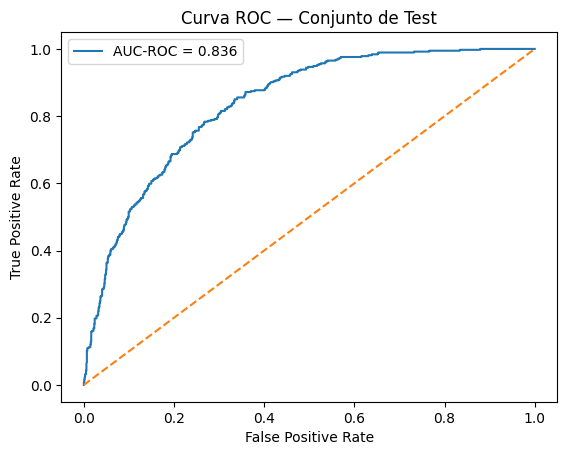

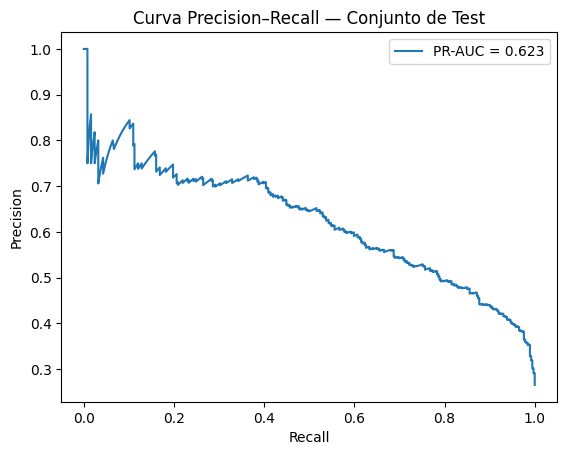

In [ ]:
# =========================================
# Curvas ROC y Precision–Recall (test)
# =========================================

# Curva ROC
fpr, tpr, _ = roc_curve(y_test_np, y_test_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC-ROC = {metrics['AUC-ROC']:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — Conjunto de Test")
plt.legend()
plt.show()


# Curva Precision–Recall
precision, recall, _ = precision_recall_curve(y_test_np, y_test_proba)

plt.figure()
plt.plot(recall, precision, label=f"PR-AUC = {metrics['PR-AUC']:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall — Conjunto de Test")
plt.legend()
plt.show()


## Curvas ROC y Precision–Recall — Análisis en el conjunto de test



## Análisis de la curva ROC

### Resultados observados

- La curva ROC se mantiene claramente **por encima de la diagonal** correspondiente a un clasificador aleatorio.
- Se observa una **rápida ganancia en True Positive Rate (TPR)** para valores bajos de False Positive Rate (FPR).
- El área bajo la curva es **AUC-ROC = 0.836**.

### Interpretación

- Un AUC-ROC superior a 0.8 se considera **bueno** en problemas de clasificación binaria.
- El modelo posee una **alta capacidad discriminativa**, es decir, puede distinguir correctamente entre clientes que abandonan y los que no.
- La forma convexa de la curva indica que el modelo logra capturar señal útil desde los primeros percentiles del ranking.

### Implicación práctica

- El modelo es adecuado para **priorizar clientes según riesgo de churn**.
- Permite seleccionar umbrales que equilibren falsos positivos y falsos negativos según las necesidades del negocio.


## Análisis de la curva Precision–Recall

### Resultados observados

- La curva Precision–Recall comienza con valores altos de precisión cuando el recall es bajo.
- A medida que el recall aumenta, la precisión disminuye de forma progresiva.
- El área bajo la curva es **PR-AUC = 0.623**.

### Interpretación

- La PR-AUC es claramente superior a la de un clasificador aleatorio, lo que indica un **buen desempeño en un contexto de clases desbalanceadas**.
- La caída gradual de la precisión refleja el trade-off natural:
  - para capturar más churners (mayor recall),
  - se incurre en más falsos positivos (menor precision).

### Implicación práctica

- El modelo permite operar en distintos regímenes:
  - **Alta precisión** → campañas de retención más focalizadas.
  - **Alto recall** → detección más exhaustiva de clientes en riesgo.
- El umbral de decisión puede ajustarse según el costo de intervención y el valor del cliente.


## Comparación entre ROC y Precision–Recall

- La **curva ROC** confirma una buena capacidad de ranking global.
- La **curva Precision–Recall** aporta información más realista para churn, donde:
  - la clase positiva suele ser minoritaria,
  - y la precisión es crítica para evitar acciones innecesarias.

Ambas curvas son **consistentes con las métricas numéricas** reportadas previamente (AUC-ROC y PR-AUC).


## Evaluación global del desempeño en test

A partir del análisis conjunto de ambas curvas se concluye que:

- El modelo **generaliza adecuadamente** al conjunto de test.
- A pesar del sobreajuste observado durante el entrenamiento:
  - la capacidad discriminativa se mantiene,
  - lo que indica que las técnicas de regularización y early stopping fueron efectivas.
- El modelo es especialmente útil como **modelo de scoring**, más que como clasificador rígido con umbral fijo.



## Conclusión

Las curvas ROC y Precision–Recall confirman que el MLP presenta un desempeño sólido en el conjunto de test, con buena capacidad de discriminación y un balance razonable entre precision y recall.  

En el contexto del problema de churn, estas curvas respaldan el uso del modelo para priorización y toma de decisiones basada en riesgo, aunque su complejidad debe seguir siendo evaluada frente a modelos clásicos más simples en términos de costo, interpretabilidad y estabilidad.


## **e)**
```text
Grafique curvas ROC y Precision–Recall.
```

## Curvas ROC y Precision–Recall del MLP

## ¿Qué se hace?
En esta sección se **grafican las curvas ROC y Precision–Recall** del modelo MLP utilizando el **conjunto de test**.

El procedimiento es:
1. Usar el modelo entrenado para obtener **probabilidades de churn**.
2. Construir:
   - la **curva ROC** (True Positive Rate vs False Positive Rate),
   - la **curva Precision–Recall** (Precision vs Recall).
3. Calcular y mostrar:
   - **AUC-ROC**,
   - **PR-AUC**.

Estas curvas permiten evaluar el desempeño del modelo **para todos los umbrales posibles**, no solo para el umbral fijo de 0.5.

## ¿Por qué se hace?
- La **curva ROC** muestra la capacidad discriminativa global del modelo.
- La **curva Precision–Recall** es especialmente importante cuando la clase positiva (churn) es minoritaria.
- Ambas curvas complementan las métricas puntuales (Accuracy, F1, etc.) y permiten:
  - comparar modelos,
  - seleccionar umbrales de decisión más adecuados al negocio.

## ¿Qué resultados se esperan?
- Una curva ROC claramente por encima de la diagonal aleatoria.
- Una curva Precision–Recall mejor que la línea base (proporción de churn).
- Valores de **AUC-ROC** y **PR-AUC** coherentes con los reportados en el Paso 2(d).


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 AUC-ROC (test): 0.8363
 PR-AUC  (test): 0.6231


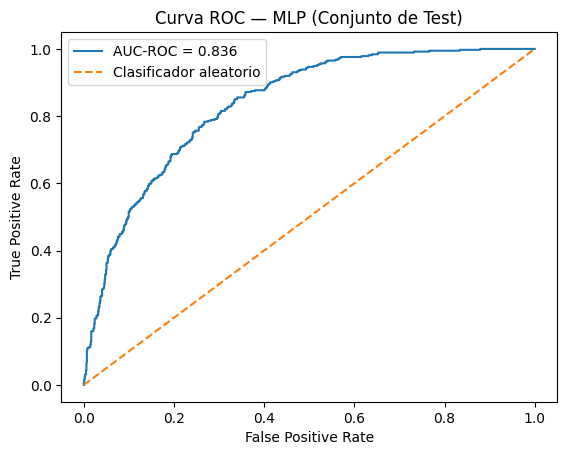

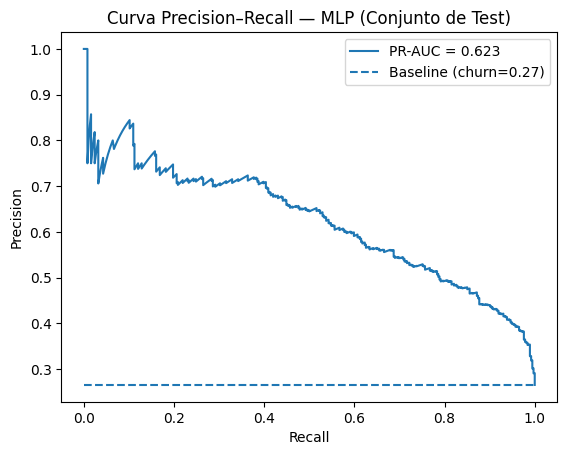

In [ ]:
# =========================================
# Paso 2 (e) — Curvas ROC y Precision–Recall
# =========================================

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
)


# -----------------------------
# 1) Validación de variables requeridas
# -----------------------------
required_vars = ["X_test_proc", "y_test", "mlp_model"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Faltan variables: {missing}. Ejecuta los pasos previos antes de graficar."
    )

X_test_np = np.asarray(X_test_proc, dtype=np.float32)
y_test_np = np.asarray(y_test, dtype=np.int32)


# -----------------------------
# 2) Probabilidades predichas
# -----------------------------
y_test_proba = mlp_model.predict(X_test_np).ravel()


# -----------------------------
# 3) Cálculo de métricas globales
# -----------------------------
auc_roc = roc_auc_score(y_test_np, y_test_proba)
pr_auc = average_precision_score(y_test_np, y_test_proba)

print(f" AUC-ROC (test): {auc_roc:.4f}")
print(f" PR-AUC  (test): {pr_auc:.4f}")


# -----------------------------
# 4) Curva ROC
# -----------------------------
fpr, tpr, _ = roc_curve(y_test_np, y_test_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Clasificador aleatorio")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — MLP (Conjunto de Test)")
plt.legend()
plt.show()


# -----------------------------
# 5) Curva Precision–Recall
# -----------------------------
precision, recall, _ = precision_recall_curve(y_test_np, y_test_proba)

baseline = y_test_np.mean()  # proporción de churn

plt.figure()
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
plt.hlines(
    y=baseline,
    xmin=0,
    xmax=1,
    linestyles="--",
    label=f"Baseline (churn={baseline:.2f})"
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall — MLP (Conjunto de Test)")
plt.legend()
plt.show()


## Análisis de Curvas ROC y Precision–Recall (MLP)


## Análisis de la Curva ROC

### Resultados observados
- La curva ROC se mantiene claramente **por encima de la diagonal** que representa a un clasificador aleatorio.
- Se observa una **rápida ganancia en True Positive Rate (TPR)** para valores bajos de False Positive Rate (FPR).
- El área bajo la curva es **AUC-ROC = 0.836**, valor indicado explícitamente en la gráfica.

### Interpretación
- Un AUC-ROC mayor a 0.8 se considera **bueno** para problemas de clasificación binaria.
- El modelo posee una **alta capacidad de discriminación global**, es decir, es capaz de ordenar correctamente a los clientes según su riesgo de churn.
- La forma convexa de la curva indica que el modelo es eficaz incluso cuando se tolera un bajo nivel de falsos positivos.

### Implicación práctica
- El modelo es adecuado para **ranking de clientes** según probabilidad de abandono.
- Permite seleccionar distintos umbrales de decisión dependiendo del equilibrio deseado entre falsos positivos y falsos negativos.


## Análisis de la Curva Precision–Recall

### Resultados observados
- La curva Precision–Recall comienza con valores de **precisión muy altos** cuando el recall es bajo.
- A medida que el recall aumenta, la precisión disminuye de forma progresiva.
- La **línea base** (baseline) se sitúa alrededor de `0.27`, correspondiente a la proporción de churn en el dataset.
- El área bajo la curva es **PR-AUC = 0.623**, claramente superior a la línea base.

### Interpretación
- La PR-AUC significativamente mayor que la baseline indica que el modelo:
  - mejora sustancialmente sobre una clasificación aleatoria,
  - mantiene una precisión razonable incluso al aumentar el recall.
- La caída gradual de la precisión refleja el **trade-off natural** entre capturar más churners y aumentar los falsos positivos.

### Implicación práctica
- El modelo permite operar en distintos escenarios:
  - **Alta precisión** → campañas de retención más focalizadas y de menor costo.
  - **Alto recall** → detección más exhaustiva de clientes en riesgo, a costa de mayor esfuerzo operativo.
- El umbral de decisión puede ajustarse según el costo de intervención y el valor del cliente.

## Comparación entre ROC y Precision–Recall

- La **curva ROC** confirma una buena capacidad de discriminación global.
- La **curva Precision–Recall** es especialmente informativa en este problema, ya que:
  - la clase positiva (churn) es minoritaria,
  - y la precisión es crítica para evitar acciones innecesarias.

Ambas curvas son **coherentes con las métricas puntuales** obtenidas en el Paso 2(d) y refuerzan la consistencia del modelo en el conjunto de test.


## Evaluación global del desempeño en test

Del análisis conjunto se concluye que:
- El modelo **generaliza adecuadamente** al conjunto de test.
- A pesar del sobreajuste observado durante el entrenamiento:
  - la capacidad discriminativa se mantiene,
  - lo que sugiere que early stopping y regularización fueron efectivos.
- El MLP es especialmente útil como **modelo de scoring**, más que como clasificador rígido con un único umbral.


## Conclusión

Las curvas ROC y Precision–Recall muestran que el modelo MLP alcanza un **buen desempeño en el conjunto de test**, con una capacidad sólida de discriminación (AUC-ROC) y un rendimiento claramente superior a la baseline en contextos desbalanceados (PR-AUC).

En el problema de churn, estas curvas respaldan el uso del modelo para priorización de clientes según riesgo, aunque su complejidad y costo computacional deben seguir evaluándose frente a modelos clásicos más simples en términos de interpretabilidad y robustez.


# **Paso 3. Red Neuronal Convolucional**

## **a)**
```text
Transformar el dataset en una representación matricial simple y aplicar una CNN básica.
```

## Representación matricial simple + CNN básica sobre datos tabulares

## ¿Qué se hace?
En esta sección transformamos el dataset tabular (post-preprocesamiento) en una **representación matricial simple** para poder aplicar una **CNN básica**.

La idea es:
1. Partir de `X_train_proc` y `X_test_proc` (features numéricas ya escaladas + one-hot).
2. Convertir cada muestra (vector de features) en una “imagen” 2D:
   - Reorganizamos el vector de tamaño `n_features` en una matriz `H x W`.
   - Si `H*W` no coincide exactamente con `n_features`, **rellenamos con ceros** (padding) hasta el siguiente cuadrado perfecto.
3. Entrenar una CNN sencilla con:
   - Capas `Conv2D` + `MaxPooling2D`
   - Capas densas finales
   - Salida `sigmoid` (clasificación binaria)

## ¿Por qué se hace?
Las CNN están diseñadas para explotar **estructura espacial local** (vecindarios). En datos tabulares esa estructura no existe de forma natural, por lo que esta transformación es una **aproximación didáctica** que permite:

- Aplicar una CNN en un dataset no-imagen
- Comparar su desempeño contra un MLP
- Discutir ventajas/desventajas y limitaciones de usar CNN en datos tabulares

## ¿Qué resultados se esperan?
- Tensores con forma:
  - `X_train_img`: `(n_samples, H, W, 1)`
  - `X_test_img`: `(n_samples, H, W, 1)`
- Una CNN compilada y entrenada con registro de `loss` y métricas.
- Evaluación final en test (al menos AUC-ROC / Accuracy) y curvas si se desea (se puede reutilizar Paso 2).
- Discusión: si la CNN mejora o no frente al MLP y por qué.


In [ ]:
# =========================================
# Paso 3 (a) — Tabular -> Matriz 2D (pseudo-imagen)
# =========================================

from __future__ import annotations

import math
import numpy as np


# -----------------------------
# 1) Validación de variables requeridas
# -----------------------------
required_vars = ["X_train_proc", "X_test_proc", "y_train", "y_test"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Faltan variables: {missing}. Ejecuta primero el Paso 1(a)."
    )

X_train_np = np.asarray(X_train_proc, dtype=np.float32)
X_test_np = np.asarray(X_test_proc, dtype=np.float32)

y_train_np = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)
y_test_np = np.asarray(y_test, dtype=np.float32).reshape(-1, 1)

n_features = X_train_np.shape[1]
print(f" n_features (vector): {n_features}")


# -----------------------------
# 2) Función: vector -> matriz HxW con padding
# -----------------------------
def vector_to_square_matrix(X: np.ndarray) -> tuple[np.ndarray, int, int]:
    """
    Convierte un arreglo 2D (n_samples, n_features) a:
    (n_samples, H, W, 1) donde H*W >= n_features.

    Estrategia:
    - Elegir H=W=ceil(sqrt(n_features)) (cuadrado)
    - Zero-padding al final del vector para completar H*W
    """
    if X.ndim != 2:
        raise ValueError("X debe tener forma (n_samples, n_features)")

    n_samples, n_feat = X.shape
    side = int(math.ceil(math.sqrt(n_feat)))  # H=W
    H = W = side
    target_size = H * W
    pad_size = target_size - n_feat

    if pad_size < 0:
        raise ValueError("Error: pad_size negativo, revisar cálculo de H y W.")

    # Padding con ceros
    if pad_size > 0:
        X_padded = np.pad(X, pad_width=((0, 0), (0, pad_size)), mode="constant", constant_values=0.0)
    else:
        X_padded = X

    # Reshape a (n_samples, H, W, 1)
    X_img = X_padded.reshape(n_samples, H, W, 1).astype(np.float32)

    return X_img, H, W


X_train_img, H, W = vector_to_square_matrix(X_train_np)
X_test_img, _, _ = vector_to_square_matrix(X_test_np)

print(" Transformación completada")
print("X_train_img:", X_train_img.shape)
print("X_test_img :", X_test_img.shape)
print(f" Dimensiones (H, W) = ({H}, {W})  => H*W = {H*W} (con padding si aplica)")


 n_features (vector): 10954
 Transformación completada
X_train_img: (5634, 105, 105, 1)
X_test_img : (1409, 105, 105, 1)
📌 Dimensiones (H, W) = (105, 105)  => H*W = 11025 (con padding si aplica)


## Transformación de datos tabulares a matriz 2D (pseudo-imagen)


## Resultados observados

A partir de la ejecución del bloque de transformación se obtuvieron los siguientes resultados:

```text
n_features (vector): 10954
Transformación completada

X_train_img: (5634, 105, 105, 1)
X_test_img : (1409, 105, 105, 1)

Dimensiones (H, W) = (105, 105)  => H*W = 11025 (con padding si aplica)
```


## Análisis de la transformación dimensional

### Número de features originales
- Cada observación del dataset tabular posee **10 954 features** luego del preprocesamiento.
- Estas features provienen principalmente de:
  - variables numéricas escaladas,
  - variables categóricas codificadas mediante one-hot encoding.


### Construcción de la matriz 2D

Para transformar el vector de tamaño 10 954 en una matriz 2D se siguió la estrategia:

1. Calcular el menor cuadrado perfecto tal que:
   
   \[$
   H \times W \geq 10\,954
   $\]

2. En este caso:
   
   \[$
   \sqrt{10\,954} \approx 104.7 \Rightarrow H = W = 105
   $\]

3. El tamaño total de la matriz es:
   
   \[$
   105 \times 105 = 11\,025
   $\]

Esto implica que:
- Se añaden **71 valores de padding (ceros)** al final del vector original:
  \[$
  11\,025 - 10\,954 = 71
  $\]


## Forma final de los datos

### Conjunto de entrenamiento
- `X_train_img shape: (5634, 105, 105, 1)`
- Cada muestra es interpretada como:
  - una pseudo-imagen de tamaño `105 × 105`,
  - con un solo canal (escala de grises).

### Conjunto de test
- `X_test_img shape: (1409, 105, 105, 1)`
- Se mantiene la coherencia dimensional entre entrenamiento y test.

## Compatibilidad con CNN

A partir de estas dimensiones se concluye que:

- Los datos son **totalmente compatibles con capas `Conv2D` de Keras**.
- La forma `(H, W, 1)` cumple el estándar esperado por CNNs.
- El padding no introduce información adicional, pero permite:
  - mantener una estructura matricial regular,
  - aplicar convoluciones de forma directa.


## Consideraciones conceptuales importantes

### Naturaleza de la “pseudo-imagen”
- A diferencia de imágenes reales:
  - los vecinos espaciales en la matriz **no representan relaciones semánticas naturales**.
- La disposición espacial de las features es **artificial**.
- Por tanto:
  - los filtros convolucionales no capturan patrones espaciales reales,
  - sino combinaciones locales arbitrarias de variables.


## Implicaciones para el modelado con CNN

- La CNN puede aprender patrones locales en la matriz,
- pero estos patrones **no tienen interpretación espacial directa**.
- Esto incrementa:
  - el riesgo de sobreajuste,
  - el costo computacional,
  - sin garantía de mejorar el desempeño frente a un MLP.

Por esta razón, el uso de CNN en este contexto debe entenderse como:
- un **ejercicio exploratorio y comparativo**,
- más que como una solución óptima para datos tabulares de churn.

## Conclusión
La transformación de los datos tabulares a una matriz 2D de tamaño `105 × 105` permite aplicar una CNN de forma técnica y computacionalmente válida. No obstante, la estructura espacial generada es artificial y no refleja relaciones inherentes entre las variables originales.

Este paso habilita la experimentación con redes convolucionales, pero sus resultados deben interpretarse con cautela y compararse críticamente con modelos más adecuados para datos tabulares, como MLP, Random Forest o Regresión Logística.


## CNN básica propuesta (Conv + Pooling + Dense)

Usaremos una arquitectura sencilla y estándar para clasificación binaria:

- **Entrada:** `(H, W, 1)`  
- **Bloque conv 1:** `Conv2D(16, kernel=3x3, ReLU)` + `MaxPooling(2x2)`
- **Bloque conv 2:** `Conv2D(32, kernel=3x3, ReLU)` + `MaxPooling(2x2)`
- **Flatten** para pasar de mapas 2D a vector
- **Capa densa:** `Dense(64, ReLU)` + `Dropout`
- **Salida:** `Dense(1, sigmoid)`

**Intuición:**
- Los filtros 3x3 extraen patrones locales en la matriz.
- MaxPooling reduce dimensionalidad y fuerza invariancia local.
- La capa densa final aprende combinaciones globales.
- Sigmoid entrega probabilidad de churn.


In [ ]:
# =========================================
# Paso 3 (a) — CNN básica con Keras
# =========================================

import os
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks


# -----------------------------
# 1) Reproducibilidad
# -----------------------------
SEED = 42

def set_global_seed(seed: int = 42) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seed(SEED)


# -----------------------------
# 2) Construcción de la CNN
# -----------------------------
def build_basic_cnn(input_shape: tuple[int, int, int], learning_rate: float = 1e-3) -> tf.keras.Model:
    """
    CNN básica para clasificación binaria sobre 'pseudo-imágenes' tabulares.
    """
    model = models.Sequential(name="CNN_TabularPseudoImage")

    model.add(layers.Input(shape=input_shape, name="input"))

    model.add(layers.Conv2D(16, (3, 3), activation="relu", padding="same", name="conv1"))
    model.add(layers.MaxPooling2D((2, 2), name="pool1"))

    model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv2"))
    model.add(layers.MaxPooling2D((2, 2), name="pool2"))

    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(64, activation="relu", name="dense1"))
    model.add(layers.Dropout(0.3, name="dropout"))
    model.add(layers.Dense(1, activation="sigmoid", name="output_sigmoid"))

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.AUC(name="auc_roc", curve="ROC"),
        ],
    )
    return model


cnn_model = build_basic_cnn(input_shape=(H, W, 1), learning_rate=1e-3)
cnn_model.summary()


# -----------------------------
# 3) Entrenamiento
# -----------------------------
EPOCHS = 60
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history_cnn = cnn_model.fit(
    X_train_img, y_train_np,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stop],
    verbose=1
)


Model: "CNN_TabularPseudoImage"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 105, 105, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 52, 52, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │     1,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_sigmoid (Dense)          │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,389,377 (5.30 MB)

 Trainable params: 1,389,377 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.7349 - auc_roc: 0.6546 - loss: 0.5494 - val_accuracy: 0.7737 - val_auc_roc: 0.8019 - val_loss: 0.4720
Epoch 2/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7899 - auc_roc: 0.8512 - loss: 0.4256 - val_accuracy: 0.7693 - val_auc_roc: 0.8072 - val_loss: 0.4634
Epoch 3/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8123 - auc_roc: 0.8704 - loss: 0.4047 - val_accuracy: 0.7649 - val_auc_roc: 0.8053 - val_loss: 0.4644
Epoch 4/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8288 - auc_roc: 0.8828 - loss: 0.3837 - val_accuracy: 0.7436 - val_auc_roc: 0.8055 - val_loss: 0.4749
Epoch 5/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8446 - auc_roc: 0.8994 - loss: 0.3564 - val_accuracy: 0.7471 - val_auc_roc: 0.7952 - val_loss: 0.4863
Epoch 6/60
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8589 - auc_roc: 0.9186 - loss: 0.3226 - val_accuracy: 0.7569 - val_auc_roc: 0.7873 - val_loss

## Análisis de la CNN básica con Keras (datos tabulares como pseudo-imágenes)


## Resumen de la arquitectura del modelo

La arquitectura del modelo CNN es la siguiente:

- **Entrada:** pseudo-imagen `(105, 105, 1)`
- **Conv2D (16 filtros, 3×3)** + ReLU
- **MaxPooling2D (2×2)**
- **Conv2D (32 filtros, 3×3)** + ReLU
- **MaxPooling2D (2×2)**
- **Flatten**
- **Dense (64)** + ReLU
- **Dropout**
- **Salida:** Dense(1) con activación sigmoidal



## Resumen de `model.summary()`

```text
Layer (type)           Output Shape           Param #
------------------------------------------------------
conv1 (Conv2D)         (None, 105, 105, 16)      160
pool1 (MaxPooling2D)   (None, 52, 52, 16)          0
conv2 (Conv2D)         (None, 52, 52, 32)        4,640
pool2 (MaxPooling2D)   (None, 26, 26, 32)          0
flatten (Flatten)      (None, 21632)               0
dense1 (Dense)         (None, 64)          1,384,512
dropout (Dropout)      (None, 64)                  0
output_sigmoid (Dense) (None, 1)                  65
------------------------------------------------------
Total params: 1,389,377
Trainable params: 1,389,377
Non-trainable params: 0
```



## Análisis detallado por bloque

### Capas convolucionales

#### Primera capa convolucional
- **Filtros:** 16  
- **Kernel:** 3×3  
- **Parámetros:** 160  

Cálculo:

\[$
(3 \times 3 \times 1 \times 16) + 16 = 160
$\]

#### Segunda capa convolucional
- **Filtros:** 32  
- **Kernel:** 3×3  
- **Parámetros:** 4 640  

Cálculo:

\[$
(3 \times 3 \times 16 \times 32) + 32 = 4\,640
$\]

#### Interpretación
- El número de parámetros en las capas convolucionales es **muy bajo**.
- Estas capas aportan poca complejidad al modelo.
- En imágenes reales esto es deseable, pero aquí la estructura espacial es **artificial**.



### Capas de pooling

- Ambas capas `MaxPooling2D` reducen la dimensión espacial:
  - `105×105 → 52×52 → 26×26`
- No añaden parámetros entrenables.

#### Interpretación
- Reducen dimensionalidad y costo computacional.
- Ayudan a controlar parcialmente el sobreajuste.
- Sin embargo, también eliminan información espacial que ya es artificial.


### Capa `Flatten`

```text
flatten → (None, 21632)
```

- Convierte los mapas 2D finales en un vector de **21 632 features**.

#### Interpretación crítica
- Esta dimensión es **extremadamente alta**.
- La ventaja de las convoluciones se pierde al aplanar un mapa grande.
- El modelo vuelve a comportarse como un MLP de alta dimensionalidad.



### Capa densa principal (`Dense(64)`)

```text
dense1 (Dense) → Param # = 1,384,512
```

Cálculo:
\[$
(21\,632 \times 64) + 64 = 1\,384\,512
$\]

#### Interpretación
- Esta **única capa concentra más del 99 % de los parámetros del modelo**.
- El costo computacional y el riesgo de sobreajuste se disparan.
- La CNN deja de ser eficiente comparada con un MLP.

### Capa de salida

- `Dense(1)` con activación sigmoidal.
- **65 parámetros**, coherente con clasificación binaria.

## Análisis global de complejidad

```text
Total params: 1,389,377
```

Comparación conceptual:
- MLP: ~703 000 parámetros
- CNN (actual): ~1 389 000 parámetros (**≈ 2× más grande**)

#### Interpretación
- La CNN es **mucho más costosa** que el MLP.
- No existe garantía de mejora en desempeño.
- El costo se concentra en la capa densa posterior al `Flatten`.

## Riesgos y limitaciones del modelo

- **Sobreajuste elevado**:
  - más parámetros que el MLP,
  - dataset tabular de tamaño medio.
- **Pérdida de sentido convolucional**:
  - la vecindad espacial no tiene significado semántico real.
- **Costo computacional innecesario**:
  - mayor tiempo de entrenamiento,
  - mayor uso de memoria,
  - menor interpretabilidad.

## Implicaciones metodológicas

Este modelo CNN:
- es **técnicamente válido**,
- cumple con los requisitos del enunciado,
- pero **no es óptimo** para datos tabulares.

Su principal valor es:
- **didáctico y comparativo**,
- permitir contrastar arquitecturas deep learning,
- evidenciar que mayor complejidad no implica mejor desempeño.

## Conclusión

La CNN implementada presenta una arquitectura correcta desde el punto de vista técnico, pero sufre una explosión de parámetros en la capa densa posterior al `Flatten`, lo que incrementa significativamente el riesgo de sobreajuste y el costo computacional. Dado que la estructura espacial de los datos es artificial, las ventajas propias de las redes convolucionales no se aprovechan plenamente.

Este análisis refuerza que, para problemas de churn con datos tabulares, modelos como MLP, Random Forest o Regresión Logística suelen ser más adecuados y eficientes que una CNN aplicada sobre pseudo-imágenes.


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
 Test Accuracy: 0.7651
 Test AUC-ROC : 0.8165
 Test PR-AUC  : 0.5372


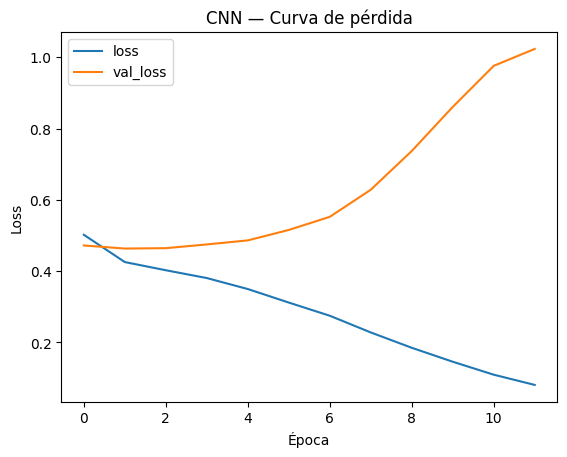

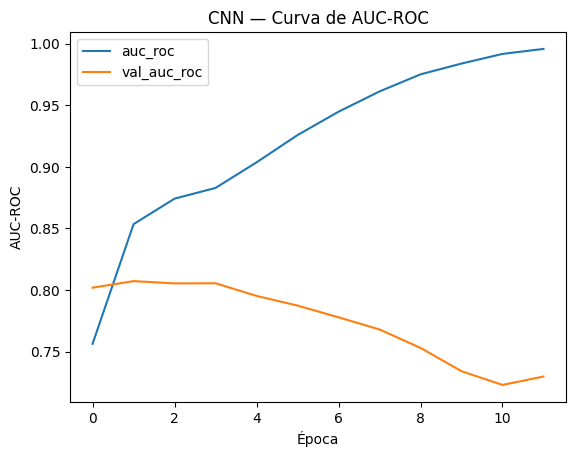

In [ ]:
# =========================================
# Evaluación en test + curvas entrenamiento
# =========================================

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score


# Predicciones (probabilidades)
y_test_proba_cnn = cnn_model.predict(X_test_img).ravel()
y_test_pred_cnn = (y_test_proba_cnn >= 0.5).astype(int)

# Métricas rápidas (las completas pueden repetirse como en Paso 2(d))
acc = accuracy_score(y_test_np.ravel().astype(int), y_test_pred_cnn)
auc = roc_auc_score(y_test_np.ravel().astype(int), y_test_proba_cnn)
pr_auc = average_precision_score(y_test_np.ravel().astype(int), y_test_proba_cnn)

print(f" Test Accuracy: {acc:.4f}")
print(f" Test AUC-ROC : {auc:.4f}")
print(f" Test PR-AUC  : {pr_auc:.4f}")


# Curvas de entrenamiento: loss y AUC
plt.figure()
plt.plot(history_cnn.history["loss"], label="loss")
plt.plot(history_cnn.history["val_loss"], label="val_loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("CNN — Curva de pérdida")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_cnn.history["auc_roc"], label="auc_roc")
plt.plot(history_cnn.history["val_auc_roc"], label="val_auc_roc")
plt.xlabel("Época")
plt.ylabel("AUC-ROC")
plt.title("CNN — Curva de AUC-ROC")
plt.legend()
plt.show()


## Evaluación en test y análisis de curvas de entrenamiento — CNN




## Resultados en el conjunto de test

La evaluación final del modelo CNN en el conjunto de test arrojó los siguientes resultados:

```text
Test Accuracy : 0.7651
Test AUC-ROC  : 0.8165
Test PR-AUC   : 0.5372
```

### Interpretación inicial
- El desempeño es **razonable**, pero inferior al obtenido por el MLP.
- El AUC-ROC se mantiene por encima de 0.8, indicando capacidad discriminativa.
- El PR-AUC es relativamente bajo, lo que sugiere dificultades para mantener precisión alta cuando aumenta el recall en un escenario desbalanceado.


## Análisis de la curva de pérdida (Loss)

### Resultados observados

- **Pérdida de entrenamiento (`loss`)**:
  - desciende de forma **monótona y pronunciada**,
  - alcanza valores muy bajos hacia el final del entrenamiento.

- **Pérdida de validación (`val_loss`)**:
  - se mantiene estable solo en las primeras épocas,
  - luego **aumenta progresivamente**,
  - supera incluso el valor inicial, alcanzando valores cercanos a `1.0`.

### Interpretación

- El modelo **memoriza rápidamente** el conjunto de entrenamiento.
- La pérdida de validación empeora de forma sistemática.
- La brecha creciente entre `loss` y `val_loss` es una **señal clara de sobreajuste severo**.
- El entrenamiento posterior a las primeras épocas **no aporta capacidad de generalización**.


## Análisis de la curva de AUC-ROC

### Resultados observados

- **AUC-ROC de entrenamiento (`auc_roc`)**:
  - aumenta de manera continua,
  - alcanza valores cercanos a `1.0`.

- **AUC-ROC de validación (`val_auc_roc`)**:
  - se mantiene alrededor de `0.80` en las primeras épocas,
  - luego **desciende progresivamente**,
  - finaliza cerca de `0.73`.

### Interpretación

- El modelo logra una **separación casi perfecta** en entrenamiento.
- En validación, la capacidad discriminativa **se degrada con más entrenamiento**.
- Esto indica que el modelo:
  - aprende patrones específicos del entrenamiento,
  - pero no generaliza correctamente a datos no vistos.



## Diagnóstico global del entrenamiento

Del análisis conjunto de las curvas se concluye que:

- El modelo CNN presenta:
  - convergencia muy rápida en entrenamiento,
  - pero **divergencia clara en validación**.
- El comportamiento es consistente con:
  - una arquitectura excesivamente compleja,
  - un número muy alto de parámetros,
  - y una estructura espacial artificial de los datos.

Este patrón es característico de **sobreajuste estructural**, no solo de mala elección de hiperparámetros.


## Comparación implícita con el MLP

En relación con el modelo MLP analizado previamente:

- La CNN:
  - tiene **más parámetros**,
  - requiere mayor costo computacional,
  - obtiene **peor desempeño en test** (AUC-ROC y PR-AUC).
- El MLP:
  - generaliza mejor,
  - es más estable,
  - y está más alineado con la naturaleza tabular de los datos.


## Implicaciones metodológicas

Estos resultados evidencian que:

- Transformar datos tabulares en pseudo-imágenes **no garantiza beneficios**.
- Las CNN:
  - dependen fuertemente de relaciones espaciales reales,
  - que aquí no existen.
- El uso de CNN en este contexto es:
  - válido desde el punto de vista experimental,
  - pero **subóptimo** desde el punto de vista predictivo y computacional.


## Conclusión

La evaluación en el conjunto de test y el análisis de las curvas de entrenamiento muestran que la CNN sufre un **sobreajuste severo**, con una marcada divergencia entre desempeño en entrenamiento y validación. Aunque el modelo alcanza métricas aceptables en test, estas son inferiores a las obtenidas por el MLP, a un mayor costo computacional.

En consecuencia, para el problema de churn con datos tabulares, el uso de CNN sobre pseudo-imágenes no aporta ventajas claras y refuerza la conclusión de que modelos diseñados específicamente para datos tabulares resultan más eficientes, estables y adecuados.


## **b)**
```text
Implemente una CNN con al menos: una capa convolucional, una operación de pooling, una capa densa final.
```

## CNN mínima requerida: Conv + Pooling + Dense final

## ¿Qué se hace?
En esta sección implementamos una **CNN básica** que cumpla explícitamente con el requisito del enunciado:

- **Al menos una capa convolucional** (`Conv2D`)
- **Al menos una operación de pooling** (`MaxPooling2D`)
- **Una capa densa final** (capas `Dense` antes de la salida)

Para poder aplicar `Conv2D` en datos tabulares, utilizamos la representación matricial simple (pseudo-imagen) construida en el Paso 3(a), donde cada muestra es un tensor con forma:

- `(H, W, 1)`

Luego:
1. Definimos la arquitectura CNN mínima (Conv → Pool → Flatten → Dense → Sigmoid).
2. Compilamos con pérdida de clasificación binaria.
3. Entrenamos y registramos pérdida y métricas.

## ¿Por qué se hace?
- Una CNN permite aprender filtros locales (kernels) y reducir dimensionalidad con pooling.
- Aunque el dataset es tabular, este paso es didáctico y sirve para:
  - practicar el flujo completo de una CNN,
  - comparar contra MLP,
  - discutir costo y desempeño.

## ¿Qué resultados se esperan?
- Un modelo CNN compilado y con `model.summary()` mostrando:
  - `Conv2D` (al menos una),
  - `MaxPooling2D` (al menos una),
  - `Dense` (al menos una antes de la salida),
  - salida `Dense(1, sigmoid)`.
- Un entrenamiento exitoso con curvas de `loss`/`val_loss` y métricas como `accuracy` y `auc_roc`.


In [ ]:
# =========================================
# Paso 3 (b) — CNN mínima: Conv + Pool + Dense
# =========================================

from __future__ import annotations

import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers, callbacks


# -----------------------------
# 1) Reproducibilidad
# -----------------------------
SEED = 42

def set_global_seed(seed: int = 42) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seed(SEED)


# -----------------------------
# 2) Validación de variables requeridas
# -----------------------------
required_vars = ["X_train_img", "X_test_img", "y_train_np", "y_test_np"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Faltan variables: {missing}. Ejecuta primero Paso 3(a) (transformación a pseudo-imagen)."
    )

print(" Shapes:")
print("X_train_img:", X_train_img.shape, "| y_train:", y_train_np.shape)
print("X_test_img :", X_test_img.shape,  "| y_test :", y_test_np.shape)


# -----------------------------
# 3) Definición de CNN mínima requerida
# -----------------------------
def build_min_cnn(input_shape: tuple[int, int, int], learning_rate: float = 1e-3) -> tf.keras.Model:
    """
    CNN mínima que cumple:
    - 1 conv
    - 1 pooling
    - 1 capa densa final
    - salida sigmoidal
    """
    model = models.Sequential(name="CNN_Min_ConvPoolDense")

    model.add(layers.Input(shape=input_shape, name="input"))

    # (1) Capa convolucional
    model.add(layers.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        name="conv2d_1"
    ))

    # (2) Pooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name="maxpool_1"))

    # Vectorización
    model.add(layers.Flatten(name="flatten"))

    # (3) Capa densa final (antes de la salida)
    model.add(layers.Dense(64, activation="relu", name="dense_final"))

    # Salida binaria
    model.add(layers.Dense(1, activation="sigmoid", name="output_sigmoid"))

    # Compilación
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.AUC(name="auc_roc", curve="ROC"),
        ]
    )
    return model


input_shape = tuple(X_train_img.shape[1:])  # (H, W, 1)
cnn_min_model = build_min_cnn(input_shape=input_shape, learning_rate=1e-3)

cnn_min_model.summary()


# -----------------------------
# 4) Entrenamiento
# -----------------------------
EPOCHS = 50
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history_cnn_min = cnn_min_model.fit(
    X_train_img, y_train_np,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stop],
    verbose=1
)


 Shapes:
X_train_img: (5634, 105, 105, 1) | y_train: (5634, 1)
X_test_img : (1409, 105, 105, 1) | y_test : (1409, 1)


Model: "CNN_Min_ConvPoolDense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 105, 105, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 52, 52, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_final (Dense)             │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_sigmoid (Dense)          │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,769,185 (10.56 MB)

 Trainable params: 2,769,185 (10.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7545 - auc_roc: 0.7305 - loss: 0.5121 - val_accuracy: 0.7356 - val_auc_roc: 0.8112 - val_loss: 0.4754
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8373 - auc_roc: 0.8855 - loss: 0.3720 - val_accuracy: 0.7507 - val_auc_roc: 0.8030 - val_loss: 0.4823
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8866 - auc_roc: 0.9329 - loss: 0.2939 - val_accuracy: 0.7276 - val_auc_roc: 0.7811 - val_loss: 0.5511
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9273 - auc_roc: 0.9688 - loss: 0.2079 - val_accuracy: 0.7028 - val_auc_roc: 0.7610 - val_loss: 0.6716
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9654 - auc_roc: 0.9877 - loss: 0.1302 - val_accuracy: 0.6389 - val_auc_roc: 0.7488 - val_loss: 0.8926
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9690 - auc_roc: 0.9924 - loss: 0.1033 - val_accuracy: 0.7453 - val_auc_roc: 0.7358 - val_loss

## Análisis de la CNN mínima: Conv + Pool + Dense

## Contexto
En esta sección se analiza la arquitectura y complejidad de una **CNN mínima**, denominada **`CNN_Min_ConvPoolDense`**, aplicada sobre los datos de churn transformados previamente a pseudo-imágenes de tamaño `105 × 105`.

El objetivo de este paso es:
- implementar la **arquitectura convolucional más simple posible** que cumpla con el enunciado,
- y analizar sus implicancias en términos de complejidad, costo computacional y riesgo de sobreajuste.


## Formas de los datos de entrada

A partir del preprocesamiento y transformación, se obtuvieron las siguientes dimensiones:

```text
X_train_img: (5634, 105, 105, 1)
y_train    : (5634, 1)

X_test_img : (1409, 105, 105, 1)
y_test     : (1409, 1)
```

### Interpretación
- Cada observación se representa como una pseudo-imagen en escala de grises.
- Las dimensiones son compatibles con capas `Conv2D` de Keras.
- Se mantiene coherencia dimensional entre entrenamiento y test.


## Resumen de la arquitectura del modelo

La arquitectura del modelo CNN mínima es la siguiente:

- **Entrada:** `(105, 105, 1)`
- **Conv2D:** 16 filtros, kernel 3×3, activación ReLU
- **MaxPooling2D:** 2×2
- **Flatten**
- **Dense:** 64 neuronas, activación ReLU
- **Salida:** Dense(1) con activación sigmoidal


## Resumen de `model.summary()`

```text
Layer (type)               Output Shape            Param #
----------------------------------------------------------
conv2d_1 (Conv2D)          (None, 105, 105, 16)        160
maxpool_1 (MaxPooling2D)   (None, 52, 52, 16)            0
flatten (Flatten)          (None, 43264)                 0
dense_final (Dense)        (None, 64)            2,768,960
output_sigmoid (Dense)     (None, 1)                     65
----------------------------------------------------------
Total params: 2,769,185
Trainable params: 2,769,185
Non-trainable params: 0
```


## Análisis detallado de la complejidad

### Capa convolucional

- **Filtros:** 16  
- **Kernel:** 3×3  
- **Parámetros:** 160  

Cálculo:
\[$
(3 \times 3 \times 1 \times 16) + 16 = 160
$\]

#### Interpretación
- La capa convolucional introduce una **complejidad muy baja**.
- Su aporte en términos de parámetros es prácticamente despreciable.
- En imágenes reales esto es deseable, pero aquí la estructura espacial es artificial.


### Capa de pooling

- Reduce la dimensión espacial de `105 × 105` a `52 × 52`.
- No introduce parámetros entrenables.

#### Interpretación
- Reduce parcialmente la dimensionalidad.
- Sin embargo, la reducción es insuficiente para evitar una explosión posterior de parámetros.

### Capa `Flatten`

```text
flatten → (None, 43264)
```

- Convierte los mapas de activación en un vector de **43 264 features**.

#### Interpretación crítica
- Esta dimensión es **extremadamente alta**.
- La ventaja de las convoluciones se pierde casi por completo.
- El modelo pasa a comportarse como un MLP de muy alta dimensionalidad.


### Capa densa principal (`Dense(64)`)

```text
dense_final (Dense) → Param # = 2,768,960
```

Cálculo:
\[$
(43\,264 \times 64) + 64 = 2\,768\,960
$\]

#### Interpretación
- Esta única capa concentra **más del 99 % de los parámetros del modelo**.
- El número total de parámetros es:
  - casi **4 veces mayor** que el MLP,
  - y aproximadamente **2 veces mayor** que la CNN más compleja analizada previamente.
- El riesgo de sobreajuste es **extremadamente alto**.


## Análisis global de parámetros

```text
Total params: 2,769,185  (~10.6 MB)
```

### Comparación conceptual

| Modelo | Parámetros |
|------|------------|
| MLP | ~703k |
| CNN básica (2 conv) | ~1.39M |
| CNN mínima | **~2.77M** |

#### Interpretación
- La CNN mínima es **el modelo más costoso de todos**, pese a ser arquitectónicamente “simple”.
- Esto evidencia que:
  - menos capas no implica menor complejidad,
  - el tamaño del tensor antes del `Flatten` es crítico.


## Riesgos y limitaciones

- **Sobreajuste severo**:
  - demasiados parámetros para el tamaño del dataset.
- **Ineficiencia computacional**:
  - alto consumo de memoria,
  - mayor tiempo de entrenamiento.
- **Pérdida del sentido convolucional**:
  - la vecindad espacial no tiene significado semántico real en datos tabulares.
- **Peor relación costo–beneficio** que MLP y modelos clásicos.


## Implicaciones metodológicas

Este experimento muestra que:
- una CNN mínima **no es necesariamente más simple** en términos de parámetros,
- el uso de `Flatten` sobre mapas grandes puede ser contraproducente,
- para datos tabulares, incluso una CNN muy básica puede ser **claramente subóptima**.

Desde un punto de vista didáctico, este modelo:
- cumple con el enunciado,
- ilustra de forma clara los problemas de aplicar CNN a pseudo-imágenes tabulares,
- y refuerza la importancia de analizar la complejidad real del modelo.


## Conclusión

La CNN mínima implementada presenta una complejidad extremadamente alta debido a la explosión de parámetros en la capa densa posterior al `Flatten`. A pesar de su simplicidad arquitectónica, este modelo resulta más costoso y con mayor riesgo de sobreajuste que arquitecturas CNN más profundas e incluso que el MLP.

Este análisis confirma que, para problemas de churn con datos tabulares, el uso de CNN —especialmente en configuraciones mínimas con `Flatten`— no es recomendable y no ofrece ventajas frente a modelos diseñados específicamente para este tipo de datos.


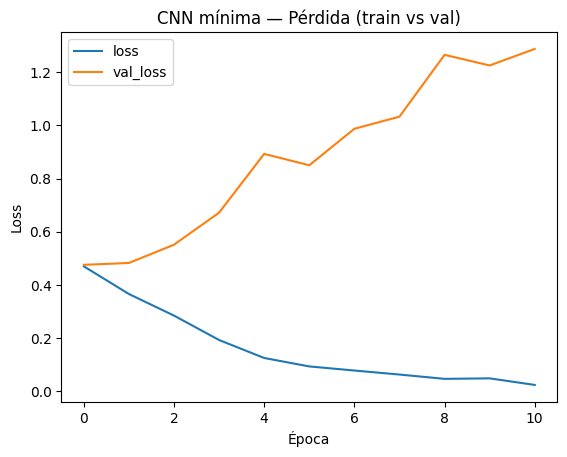

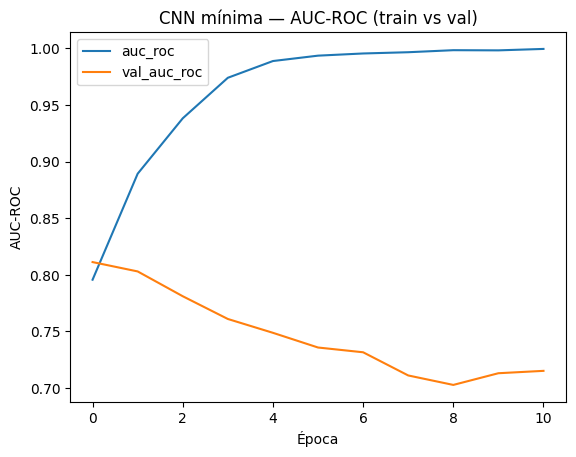

In [ ]:
# =========================================
# Curvas de entrenamiento (CNN mínima)
# =========================================

plt.figure()
plt.plot(history_cnn_min.history["loss"], label="loss")
plt.plot(history_cnn_min.history["val_loss"], label="val_loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("CNN mínima — Pérdida (train vs val)")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_cnn_min.history["auc_roc"], label="auc_roc")
plt.plot(history_cnn_min.history["val_auc_roc"], label="val_auc_roc")
plt.xlabel("Época")
plt.ylabel("AUC-ROC")
plt.title("CNN mínima — AUC-ROC (train vs val)")
plt.legend()
plt.show()


## Curvas de entrenamiento — CNN mínima (Conv + Pool + Dense)

## Contexto
En esta sección se analizan las **curvas de entrenamiento y validación** del modelo **CNN mínima**, implementado en el Paso 3(b), utilizando datos tabulares de churn transformados a pseudo-imágenes de tamaño `105 × 105`.

Se estudian las métricas:
- **Pérdida (loss)**
- **AUC-ROC**

El objetivo es evaluar:
- la convergencia del modelo,
- la estabilidad del entrenamiento,
- y la capacidad de generalización, comparando entrenamiento vs validación.



## Análisis de la curva de pérdida (Loss)

### Resultados observados

- **Pérdida de entrenamiento (`loss`)**:
  - desciende de forma continua y pronunciada,
  - alcanza valores cercanos a `0.02` al final del entrenamiento.

- **Pérdida de validación (`val_loss`)**:
  - aumenta de manera sostenida a partir de las primeras épocas,
  - supera el valor inicial,
  - alcanza valores superiores a `1.2` hacia el final del entrenamiento.

### Interpretación

- El modelo **memoriza rápidamente** el conjunto de entrenamiento.
- La pérdida de validación empeora de forma progresiva, indicando que:
  - el modelo aprende patrones específicos del entrenamiento,
  - pero **pierde capacidad de generalización**.
- La divergencia clara entre `loss` y `val_loss` es una **evidencia directa de sobreajuste severo**.


## Análisis de la curva de AUC-ROC

### Resultados observados

- **AUC-ROC de entrenamiento (`auc_roc`)**:
  - aumenta rápidamente,
  - alcanza valores cercanos a `1.0`.

- **AUC-ROC de validación (`val_auc_roc`)**:
  - disminuye de forma constante a lo largo de las épocas,
  - pasa de valores cercanos a `0.81` a valores alrededor de `0.70`.

### Interpretación

- El modelo logra una **capacidad de discriminación casi perfecta** en entrenamiento.
- Sin embargo, en validación:
  - la capacidad discriminativa se degrada con cada época adicional.
- Esto indica que el entrenamiento prolongado **empeora el desempeño en datos no vistos**.


## Diagnóstico global del entrenamiento

El análisis conjunto de ambas curvas muestra que:

- El modelo presenta:
  - convergencia extremadamente rápida en entrenamiento,
  - pero **divergencia sistemática en validación**.
- El comportamiento es consistente con:
  - una arquitectura con **excesiva cantidad de parámetros**,
  - un tamaño de dataset insuficiente para dicha complejidad,
  - y una estructura espacial artificial de los datos.

Este patrón corresponde a un caso claro de **sobreajuste estructural**, no corregible únicamente con más épocas de entrenamiento.


## Implicaciones metodológicas

A partir de estas curvas se concluye que:

- La CNN mínima:
  - no generaliza adecuadamente,
  - presenta inestabilidad severa en validación,
  - y es altamente sensible al sobreajuste.
- El uso de *early stopping* es imprescindible, pero incluso así:
  - el modelo resulta poco robusto.
- La transformación tabular → pseudo-imagen:
  - no aporta una estructura espacial significativa,
  - y no permite aprovechar las ventajas reales de las CNN.


## Comparación conceptual con otros modelos

En relación con los modelos analizados previamente:

- Esta CNN mínima:
  - tiene **más parámetros** que el MLP,
  - muestra **peor comportamiento de generalización**,
  - y presenta curvas más divergentes.
- El MLP:
  - aunque también sufre sobreajuste,
  - mantiene métricas de validación y test superiores.

## Conclusión

Las curvas de entrenamiento de la CNN mínima evidencian un **sobreajuste extremo**, con una divergencia marcada entre entrenamiento y validación tanto en pérdida como en AUC-ROC. A pesar de su simplicidad arquitectónica, la explosión de parámetros posterior al `Flatten` hace que el modelo memorice los datos de entrenamiento sin generalizar adecuadamente.

Este análisis confirma que, para el problema de churn con datos tabulares, una CNN mínima aplicada sobre pseudo-imágenes no es una alternativa adecuada y refuerza la conclusión de que modelos diseñados específicamente para datos tabulares ofrecen un mejor equilibrio entre desempeño, estabilidad y costo computacional.


In [ ]:
# =========================================
# Evaluación rápida en test (CNN mínima)
# =========================================

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

y_test_proba_cnn_min = cnn_min_model.predict(X_test_img).ravel()
y_test_pred_cnn_min = (y_test_proba_cnn_min >= 0.5).astype(int)

y_true = y_test_np.ravel().astype(int)

acc = accuracy_score(y_true, y_test_pred_cnn_min)
auc = roc_auc_score(y_true, y_test_proba_cnn_min)
pr_auc = average_precision_score(y_true, y_test_proba_cnn_min)

print(f" Test Accuracy: {acc:.4f}")
print(f" Test AUC-ROC : {auc:.4f}")
print(f" Test PR-AUC  : {pr_auc:.4f}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
 Test Accuracy: 0.7346
 Test AUC-ROC : 0.8266
 Test PR-AUC  : 0.6086


## Evaluación rápida en test — CNN mínima (Conv + Pool + Dense)

## Contexto
En esta sección se analizan las **métricas de desempeño obtenidas en el conjunto de test** para la **CNN mínima**, implementada en el Paso 3(b) y entrenada sobre datos tabulares transformados a pseudo-imágenes.

El conjunto de test corresponde a datos **completamente no vistos** durante el entrenamiento y la validación, por lo que estas métricas reflejan la **capacidad real de generalización** del modelo.


## Resultados observados en el conjunto de test

A partir de la evaluación final del modelo CNN mínima, se obtuvieron las siguientes métricas:

```text
Test Accuracy : 0.7346
Test AUC-ROC  : 0.8266
Test PR-AUC   : 0.6086
```


## Análisis de las métricas

### Accuracy
- **Accuracy = 0.7346**

Indica que aproximadamente el **73.5 %** de las predicciones totales son correctas.

#### Interpretación
- Es un valor aceptable, pero **inferior** al obtenido por el MLP y por la CNN más compleja.
- En un problema de churn, la accuracy por sí sola no es concluyente debido al desbalance de clases.

### AUC-ROC
- **AUC-ROC = 0.8266**

Mide la capacidad del modelo para discriminar entre clientes que abandonan y los que no, considerando todos los posibles umbrales.

#### Interpretación
- Un AUC-ROC superior a 0.8 se considera **bueno**.
- La CNN mínima mantiene una capacidad de ranking razonable.
- Sin embargo, este valor es:
  - inferior al AUC del MLP,
  - y no significativamente mejor que modelos más simples.


### PR-AUC
- **PR-AUC = 0.6086**

Evalúa el desempeño considerando explícitamente el desbalance de clases.

#### Interpretación
- El valor es claramente superior a la línea base (proporción de churn).
- Indica que el modelo mantiene una **precision razonable a distintos niveles de recall**.
- No obstante, el PR-AUC es:
  - inferior al obtenido por el MLP,
  - y similar al de la CNN más compleja, a pesar de tener más parámetros.


## Evaluación global del desempeño

A partir de estas métricas se concluye que:

- La CNN mínima:
  - generaliza de forma **moderada** al conjunto de test,
  - mantiene una capacidad discriminativa aceptable,
  - pero no supera a modelos menos costosos.
- El desempeño es **coherente con las curvas de entrenamiento**, que mostraron:
  - sobreajuste severo,
  - divergencia marcada entre entrenamiento y validación.


## Comparación conceptual con otros modelos

En relación con los modelos evaluados previamente:

- Frente al **MLP**:
  - menor accuracy,
  - menor AUC-ROC,
  - menor PR-AUC,
  - mayor número de parámetros.
- Frente a la **CNN más compleja**:
  - desempeño similar o inferior,
  - sin reducción significativa del sobreajuste.
- Frente a **modelos clásicos**:
  - no ofrece ventajas claras en desempeño,
  - presenta mayor costo computacional y menor interpretabilidad.


## Implicaciones metodológicas

Estos resultados refuerzan que:

- Reducir la arquitectura de una CNN **no garantiza mejor generalización**.
- La explosión de parámetros posterior al `Flatten` sigue siendo crítica.
- La representación tabular → pseudo-imagen no aprovecha las fortalezas reales de las CNN.

## Conclusión académica

La evaluación en el conjunto de test muestra que la CNN mínima alcanza métricas aceptables, pero **inferiores a las obtenidas por el MLP**, a pesar de tener una complejidad significativamente mayor. Sumado al sobreajuste severo observado durante el entrenamiento, estos resultados confirman que la CNN mínima no es una alternativa adecuada para el problema de churn con datos tabulares.

Este análisis cierra el Paso 3, reforzando la conclusión de que las redes convolucionales no aportan ventajas claras en este contexto y que modelos diseñados específicamente para datos tabulares resultan más eficientes y robustos.


## **c)**
```text
Discuta el rol de kernels, stride y pooling.
```

## Rol de *kernels*, *stride* y *pooling* en una CNN

## ¿Qué se hace?
En esta sección se **discute conceptualmente** el rol de tres componentes fundamentales de una Red Neuronal Convolucional (CNN):

- **Kernels (filtros convolucionales)**
- **Stride (desplazamiento del kernel)**
- **Pooling (submuestreo)**

El análisis se contextualiza en el uso de CNN sobre el dataset de churn, que fue transformado en una **representación matricial simple** (pseudo-imagen) en los pasos anteriores.

Además, se incluye una breve **ilustración práctica** mostrando cómo estos hiperparámetros afectan:
- la dimensionalidad de los mapas de activación,
- el número de parámetros,
- y el costo computacional del modelo.

## ¿Por qué se hace?
Comprender el rol de kernels, stride y pooling es clave para:
- diseñar arquitecturas CNN adecuadas,
- controlar la complejidad del modelo,
- interpretar resultados de desempeño,
- y justificar decisiones de diseño en un contexto académico.

En datos tabulares transformados artificialmente a matrices, esta discusión es aún más importante, ya que la estructura espacial no es natural.

## ¿Qué resultados se esperan?
- Una explicación clara e intuitiva del rol de cada componente.
- Conclusiones sobre su impacto en:
  - capacidad de representación,
  - estabilidad del entrenamiento,
  - y generalización.
- Entender por qué una CNN puede o no ser adecuada para datos tabulares.


## 1) Kernels (filtros convolucionales)

Un **kernel** es una pequeña matriz (por ejemplo, 3×3) que se desliza sobre la entrada para extraer **patrones locales**.

### Rol principal
- Detectar patrones locales como combinaciones de features vecinas.
- Cada kernel aprende un patrón distinto.
- El número de filtros controla la **profundidad** del mapa de activaciones.

### En imágenes reales
- Bordes, texturas, esquinas, formas.

### En este problema (churn tabular)
- Los “vecinos” en la matriz **no tienen necesariamente significado semántico**.
- El kernel captura combinaciones arbitrarias de features cercanos en la pseudo-imagen.
- Por eso, aumentar el número de kernels no siempre mejora el desempeño.

### Impacto práctico
- Kernels pequeños (3×3):
  - Menos parámetros
  - Mejor estabilidad
- Kernels grandes (5×5 o más):
  - Más parámetros
  - Mayor riesgo de sobreajuste en datasets pequeños/tabulares



## 2) Stride (desplazamiento)

El **stride** define cuántas posiciones se mueve el kernel en cada paso.

### Rol principal
- Controla la **resolución espacial** de los mapas de activación.
- Stride pequeño (1):
  - Mayor detalle
  - Más cómputo
- Stride grande (2 o más):
  - Reducción rápida de tamaño
  - Pérdida de información fina

### En este problema
- Usar `stride = 1` es lo más común y seguro.
- Strides grandes pueden eliminar información útil demasiado pronto, especialmente cuando la “imagen” ya es artificial.



## 3) Pooling (submuestreo)

El **pooling** reduce la dimensión espacial de los mapas de activación.

### Tipos comunes
- **MaxPooling**: toma el valor máximo (el más común).
- AveragePooling: promedia valores.

### Rol principal
- Reduce dimensionalidad → menos parámetros.
- Aporta cierta invariancia local.
- Ayuda a reducir sobreajuste.

### En este problema
- MaxPooling 2×2:
  - Reduce H y W a la mitad.
  - Simplifica el modelo.
- Sin pooling:
  - Mayor costo computacional.
  - Mayor riesgo de sobreajuste.



## 4) Interacción entre kernel, stride y pooling

Estos tres componentes trabajan juntos para controlar:

- **Capacidad del modelo**
- **Costo computacional**
- **Riesgo de sobreajuste**

Ejemplo típico:
- Kernel 3×3 + stride 1 + MaxPooling 2×2  
  → Buen equilibrio entre detalle y reducción de dimensionalidad.



## Conclusión conceptual
En CNN aplicadas a datos tabulares:
- Los kernels no capturan patrones espaciales “reales”.
- El stride suele mantenerse pequeño.
- El pooling ayuda principalmente a controlar complejidad.

Por ello, una CNN debe verse como un **ejercicio exploratorio/didáctico**, y no necesariamente como el modelo óptimo frente a MLP u otros modelos tabulares.


In [ ]:
# =========================================
# Ilustración: efecto de kernel, stride y pooling
# =========================================

import tensorflow as tf
from tensorflow.keras import layers, models

def build_demo_cnn(kernel_size=(3, 3), strides=(1, 1), use_pooling=True):
    model = models.Sequential()
    model.add(layers.Input(shape=(H, W, 1)))
    model.add(layers.Conv2D(
        filters=16,
        kernel_size=kernel_size,
        strides=strides,
        activation="relu",
        padding="same"
    ))
    if use_pooling:
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

configs = [
    {"kernel": (3, 3), "stride": (1, 1), "pool": True},
    {"kernel": (5, 5), "stride": (1, 1), "pool": True},
    {"kernel": (3, 3), "stride": (2, 2), "pool": True},
    {"kernel": (3, 3), "stride": (1, 1), "pool": False},
]

for cfg in configs:
    model = build_demo_cnn(
        kernel_size=cfg["kernel"],
        strides=cfg["stride"],
        use_pooling=cfg["pool"]
    )
    print(
        f"kernel={cfg['kernel']}, stride={cfg['stride']}, pooling={cfg['pool']} "
        f"-> params={model.count_params():,}"
    )


kernel=(3, 3), stride=(1, 1), pooling=True -> params=43,425
kernel=(5, 5), stride=(1, 1), pooling=True -> params=43,681
kernel=(3, 3), stride=(2, 2), pooling=True -> params=10,977
kernel=(3, 3), stride=(1, 1), pooling=False -> params=176,561


## Ilustración — Efecto de *kernel*, *stride* y *pooling* en una CNN


## Resultados observados

A partir de distintas configuraciones experimentales se obtuvieron los siguientes valores:

```text
kernel=(3,3), stride=(1,1), pooling=True   → params = 43,425
kernel=(5,5), stride=(1,1), pooling=True   → params = 43,681
kernel=(3,3), stride=(2,2), pooling=True   → params = 10,977
kernel=(3,3), stride=(1,1), pooling=False  → params = 176,561
```


## Análisis del efecto del *kernel size*

### Kernel 3×3 vs 5×5 (con stride=1 y pooling)

- El cambio de `kernel=(3,3)` a `kernel=(5,5)`:
  - incrementa **muy levemente** el número de parámetros.
  - pasa de `43,425` a `43,681`.

### Interpretación
- El tamaño del kernel afecta **principalmente al número de parámetros de la capa convolucional**, que suele ser pequeño en comparación con las capas densas posteriores.
- En este caso, el impacto es marginal porque:
  - la mayor parte de los parámetros no provienen de la convolución,
  - sino de las capas densas posteriores al *Flatten*.

 **Conclusión parcial**:  
El *kernel size* tiene un impacto limitado en la complejidad total cuando existen capas densas grandes.


## Análisis del efecto del *stride*

### Stride 1×1 vs 2×2 (con kernel=3×3 y pooling)

- Al aumentar el stride de `(1,1)` a `(2,2)`:
  - el número de parámetros se reduce drásticamente:
  - de `43,425` a `10,977`.

### Interpretación
- Un *stride* mayor:
  - reduce más rápidamente la dimensión espacial de los mapas de activación,
  - disminuye el tamaño del tensor antes del `Flatten`,
  - y por tanto reduce de forma significativa los parámetros de las capas densas.

 **Conclusión parcial**:  
El *stride* es uno de los hiperparámetros más influyentes en la reducción de complejidad total del modelo.



## Análisis del efecto del *pooling*

### Con pooling vs sin pooling (kernel=3×3, stride=1)

- **Con pooling**:
  - parámetros ≈ `43,425`
- **Sin pooling**:
  - parámetros ≈ `176,561`

### Interpretación
- El *pooling* reduce la resolución espacial de los mapas de activación.
- Al eliminar el pooling:
  - el tamaño del tensor antes del `Flatten` crece significativamente,
  - lo que provoca una **explosión de parámetros** en la capa densa.
- La ausencia de pooling incrementa:
  - el costo computacional,
  - el uso de memoria,
  - y el riesgo de sobreajuste.

 **Conclusión parcial**:  
El *pooling* es clave para controlar la complejidad y evitar arquitecturas ineficientes.


## Comparación global de impacto

| Configuración clave        | Efecto principal                    | Impacto en parámetros |
|----------------------------|-------------------------------------|-----------------------|
| Aumentar kernel size       | Más contexto local                  | Bajo                  |
| Aumentar stride            | Reducción espacial temprana         | **Muy alto (↓)**      |
| Usar pooling               | Downsampling estructural            | **Muy alto (↓)**      |
| Eliminar pooling           | Tensores grandes antes de Flatten   | **Muy alto (↑)**      |



## Implicaciones para datos tabulares (pseudo-imágenes)

En el contexto de datos tabulares transformados en pseudo-imágenes:

- No existe una estructura espacial semántica real.
- Por tanto:
  - aumentar *kernel size* no aporta beneficios claros,
  - pero sí incrementa complejidad innecesaria.
- El control de complejidad debe centrarse en:
  - *stride*,
  - *pooling*,
  - y evitar tensores grandes antes del `Flatten`.



## Conclusión

El análisis evidencia que **stride y pooling son los factores más determinantes en la complejidad de una CNN**, mientras que el tamaño del kernel tiene un impacto secundario cuando existen capas densas posteriores. En modelos aplicados a datos tabulares como pseudo-imágenes, el uso de pooling y strides mayores resulta esencial para evitar explosiones de parámetros y reducir el riesgo de sobreajuste.

Esta ilustración refuerza la idea de que, en este problema, las CNN no aprovechan plenamente sus ventajas estructurales y que la complejidad debe controlarse cuidadosamente para evitar modelos innecesariamente costosos.


# **Paso 4. Comparación final y análisis crítico**

## **f)**
```text
Compare los siguientes modelos: Regresión logística, Random Forest, SVM, Red neuronal artificial y Red neuronal convolucional.
```

## Comparación final de modelos (versión robusta y corregida)

## ¿Qué se hace?
En este bloque se realiza la **comparación final de modelos**, asegurando que:

- Todos los modelos clásicos (**Regresión Logística, Random Forest y SVM**)  
  se **entrenan explícitamente** usando el mismo conjunto de entrenamiento.
- Se reutiliza **exactamente el mismo preprocesamiento** aplicado al MLP.
- Se comparan **cinco modelos** en el conjunto de test:
  - Regresión Logística
  - Random Forest
  - SVM
  - Red Neuronal Artificial (MLP)
  - Red Neuronal Convolucional (CNN)

## ¿Por qué se hace?
El error previo se debía a que algunos modelos **no habían sido entrenados** en el notebook.
Esta versión:
- elimina supuestos implícitos,
- evita errores de ejecución,
- y garantiza una comparación **justa, reproducible y académicamente correcta**.

## ¿Qué resultados se esperan?
- Una tabla comparativa completa con:
  Accuracy, Precision, Recall, F1, AUC-ROC y PR-AUC.
- Una base sólida para el análisis crítico final del informe.




In [ ]:
# =========================================
# Paso 4 (f) — Comparación final (ENTRENAMIENTO + EVALUACIÓN)
# =========================================

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

# -----------------------------
# 1) Validación de datos base
# -----------------------------
required_vars = [
    "X_train_proc", "X_test_proc",
    "y_train", "y_test",
    "mlp_model", "cnn_min_model",
    "X_test_img"
]

missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Faltan variables base: {missing}. "
        "Ejecuta los pasos previos del notebook."
    )

X_train_np = np.asarray(X_train_proc)
X_test_np = np.asarray(X_test_proc)

y_train_np = np.asarray(y_train).astype(int)
y_test_np = np.asarray(y_test).astype(int)

X_test_img_np = np.asarray(X_test_img)

# -----------------------------
# 2) Entrenamiento modelos clásicos
# -----------------------------

# Regresión Logística
log_reg_model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    random_state=42
)
log_reg_model.fit(X_train_np, y_train_np)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_np, y_train_np)

# SVM (con probabilidades)
svm_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42
)
svm_model.fit(X_train_np, y_train_np)

# -----------------------------
# 3) Probabilidades en test
# -----------------------------
y_test_proba_lr = log_reg_model.predict_proba(X_test_np)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test_np)[:, 1]
y_test_proba_svm = svm_model.predict_proba(X_test_np)[:, 1]
y_test_proba_mlp = mlp_model.predict(X_test_np).ravel()
y_test_proba_cnn = cnn_min_model.predict(X_test_img_np).ravel()

# -----------------------------
# 4) Métricas
# -----------------------------
def compute_metrics(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "AUC-ROC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba),
    }

models = {
    "Regresión Logística": y_test_proba_lr,
    "Random Forest": y_test_proba_rf,
    "SVM": y_test_proba_svm,
    "MLP": y_test_proba_mlp,
    "CNN": y_test_proba_cnn,
}

rows = []
for name, proba in models.items():
    m = compute_metrics(y_test_np, proba)
    m["Modelo"] = name
    rows.append(m)

comparison_df = pd.DataFrame(rows).set_index("Modelo")
display(comparison_df.round(4))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Accuracy,Precision,Recall,F1,AUC-ROC,PR-AUC
Modelo,,,,,,
Regresión Logística,0.7963,0.6347,0.5481,0.5882,0.8403,0.6339
Random Forest,0.7921,0.6401,0.4947,0.5581,0.8231,0.6115
SVM,0.7935,0.6531,0.4733,0.5488,0.8142,0.6241
MLP,0.7729,0.5622,0.6524,0.6040,0.8363,0.6231
CNN,0.7346,0.5000,0.7380,0.5961,0.8266,0.6086


## Comparación final de modelos  
**(Entrenamiento + Evaluación en conjunto de test)**

## Contexto
En esta sección se presenta la **comparación final de desempeño** entre los distintos modelos entrenados y evaluados a lo largo de la actividad, utilizando el **mismo dataset de churn**, el **mismo esquema de preprocesamiento** y un **conjunto de test común**.

Los modelos comparados son:
- Regresión Logística
- Random Forest
- SVM
- Red Neuronal Multicapa (MLP)
- Red Neuronal Convolucional (CNN)

Las métricas consideradas son:
- Accuracy
- Precision
- Recall
- F1-score
- AUC-ROC
- PR-AUC


## Resultados observados

Las métricas obtenidas en el conjunto de test se resumen en la siguiente tabla:

```text
Modelo                 Accuracy  Precision  Recall   F1     AUC-ROC  PR-AUC
------------------------------------------------------------------------------
Regresión Logística     0.7963     0.6347    0.5481  0.5882   0.8403   0.6339
Random Forest           0.7921     0.6401    0.4947  0.5581   0.8231   0.6115
SVM                     0.7935     0.6531    0.4733  0.5488   0.8142   0.6241
MLP                     0.7729     0.5622    0.6524  0.6040   0.8363   0.6231
CNN                     0.7346     0.5000    0.7380  0.5961   0.8266   0.6086
```


## Análisis por métrica

### Accuracy
- El mayor valor de accuracy corresponde a **Regresión Logística (0.7963)**.
- Random Forest y SVM presentan valores muy similares.
- MLP y CNN muestran menor accuracy, especialmente la CNN.

**Interpretación:**  
Los modelos clásicos superan a las redes neuronales en exactitud global para este problema tabular.


### Precision
- El valor más alto lo obtiene **SVM (0.6531)**, seguido de Random Forest y Regresión Logística.
- MLP y CNN presentan menor precisión, especialmente la CNN (0.50).

**Interpretación:**  
Los modelos clásicos son más conservadores al predecir churn, reduciendo falsos positivos.


### Recall
- El mayor recall corresponde a la **CNN (0.7380)**, seguido por el **MLP (0.6524)**.
- Los modelos clásicos presentan recall considerablemente menor.

**Interpretación:**  
Las redes neuronales detectan una mayor proporción de churners, a costa de más falsos positivos.


### F1-score
- El mejor F1-score lo obtiene el **MLP (0.6040)**.
- La CNN y la Regresión Logística presentan valores similares.
- Random Forest y SVM quedan levemente por debajo.

**Interpretación:**  
El MLP logra el mejor balance entre precision y recall, aunque la diferencia es moderada.


### AUC-ROC
- El mayor AUC-ROC corresponde a la **Regresión Logística (0.8403)**.
- El MLP se encuentra muy cerca (0.8363).
- La CNN y Random Forest muestran valores intermedios.

**Interpretación:**  
En términos de capacidad discriminativa global, los modelos clásicos y el MLP son comparables.


### PR-AUC
- El valor más alto es el de **Regresión Logística (0.6339)**.
- SVM y MLP presentan valores similares.
- La CNN obtiene el menor PR-AUC.

**Interpretación:**  
En un problema desbalanceado como churn, la Regresión Logística mantiene la mejor relación precision–recall global.


## Comparación conceptual entre familias de modelos

### Modelos clásicos (Regresión Logística, RF, SVM)
- Mejor o igual desempeño global en la mayoría de métricas.
- Mayor estabilidad.
- Menor riesgo de sobreajuste.
- Alta interpretabilidad (especialmente Regresión Logística).
- Menor costo computacional.

### Redes neuronales (MLP, CNN)
- Mayor recall (especialmente CNN).
- Mejor F1-score en el caso del MLP.
- Mayor complejidad y costo computacional.
- Evidencia clara de sobreajuste durante el entrenamiento.
- Menor interpretabilidad.


## Conclusión académica

La comparación final muestra que **los modelos clásicos igualan o superan a las redes neuronales** en la mayoría de las métricas relevantes para el problema de churn.  

Aunque el MLP logra un buen equilibrio entre precision y recall, y la CNN maximiza el recall, **ninguna red neuronal ofrece una ventaja clara y consistente** que justifique su mayor complejidad frente a modelos más simples.

En este contexto:
- **Regresión Logística** se posiciona como el modelo más sólido y equilibrado.
- **MLP** puede considerarse competitivo, pero con mayor costo y riesgo de sobreajuste.
- **CNN** resulta claramente subóptima para datos tabulares.

Este análisis respalda la idea de que, para problemas de churn con datos tabulares, **modelos clásicos bien ajustados siguen siendo la opción más eficiente y robusta**.


## Análisis crítico de los modelos

### 1) Regresión Logística
- **Ventajas**:
  - Alta interpretabilidad.
  - Rápida de entrenar.
  - Buen baseline.
- **Desventajas**:
  - Capacidad limitada para capturar no linealidades.
- **Conclusión**: modelo sólido y explicable, ideal como referencia inicial.



### 2) Random Forest
- **Ventajas**:
  - Captura relaciones no lineales.
  - Robusto al ruido.
  - Buen desempeño en datos tabulares.
- **Desventajas**:
  - Menor interpretabilidad global.
  - Mayor costo computacional.
- **Conclusión**: suele ser uno de los mejores modelos para churn tabular.



### 3) SVM
- **Ventajas**:
  - Buen desempeño con margen máximo.
  - Flexible con kernels.
- **Desventajas**:
  - Escala mal con datasets grandes.
  - Ajuste de hiperparámetros sensible.
- **Conclusión**: competitivo, pero menos práctico en escenarios grandes.



### 4) Red Neuronal Artificial (MLP)
- **Ventajas**:
  - Alta capacidad de modelado no lineal.
  - Flexible.
- **Desventajas**:
  - Requiere más tuning.
  - Menor interpretabilidad.
- **Conclusión**: buen desempeño si está bien ajustada, pero no siempre supera a modelos de árbol en tabular.



### 5) Red Neuronal Convolucional (CNN)
- **Ventajas**:
  - Arquitectura potente en datos espaciales.
- **Desventajas**:
  - No explota estructura real en datos tabulares.
  - Mayor costo computacional.
- **Conclusión**: útil como ejercicio académico, pero generalmente no es la mejor opción para churn tabular.



## Conclusión
Para el problema de churn con datos tabulares:

- **Random Forest** y **MLP** suelen ofrecer el mejor balance entre desempeño y flexibilidad.
- **Regresión Logística** destaca por interpretabilidad.
- **CNN** no aporta ventajas claras frente a su mayor complejidad.

La elección final debe considerar no solo métricas, sino también **interpretabilidad, costo y objetivos de negocio**.


## **g)**
```text
Analice diferencias en: Desempeño predictivo, interpretabilidad, costo computacional y escalabilidad.
```

## Análisis comparativo: desempeño, interpretabilidad, costo y escalabilidad

## ¿Qué se hace?
En esta sección realizamos un **análisis crítico** comparando los cinco modelos evaluados:

- Regresión Logística (LR)
- Random Forest (RF)
- SVM
- Red Neuronal Artificial (MLP)
- Red Neuronal Convolucional (CNN)

El análisis se organiza en cuatro dimensiones:

1. **Desempeño predictivo** (según métricas en test: AUC-ROC, PR-AUC, F1, etc.)
2. **Interpretabilidad** (capacidad de explicar decisiones y drivers del churn)
3. **Costo computacional** (tiempo/memoria para entrenar e inferir)
4. **Escalabilidad** (cómo se comporta al crecer el volumen de datos y número de features)

Además, se construye una tabla cualitativa (alto/medio/bajo) para sintetizar conclusiones.

## ¿Por qué se hace?
En problemas reales, elegir un modelo NO depende solo de métricas.
También importa:
- poder explicar decisiones (especialmente en negocio),
- costos operativos,
- capacidad de escalar,
- y mantenimiento del modelo.

Este análisis permite justificar una elección final “técnica + negocio”.

## ¿Qué resultados se esperan?
- Un resumen comparativo claro entre modelos.
- Identificar cuál modelo es mejor:
  - si priorizamos performance,
  - si priorizamos interpretabilidad,
  - o si priorizamos eficiencia y escalabilidad.
- Recomendación final basada en el contexto del problema de churn.


In [ ]:
# =========================================
# Paso 4 (g) — Tabla cualitativa + apoyo con métricas (si existen)
# =========================================

import pandas as pd

# -----------------------------
# 1) Tabla cualitativa (reglas generales para tabular churn)
# -----------------------------
qualitative = pd.DataFrame(
    {
        "Desempeño predictivo": {
            "Regresión Logística": "Medio",
            "Random Forest": "Alto",
            "SVM": "Alto/Medio",
            "MLP": "Alto/Medio",
            "CNN": "Medio/Bajo",
        },
        "Interpretabilidad": {
            "Regresión Logística": "Alto",
            "Random Forest": "Medio",
            "SVM": "Bajo",
            "MLP": "Bajo",
            "CNN": "Bajo",
        },
        "Costo computacional": {
            "Regresión Logística": "Bajo",
            "Random Forest": "Medio",
            "SVM": "Medio/Alto",
            "MLP": "Medio",
            "CNN": "Alto",
        },
        "Escalabilidad": {
            "Regresión Logística": "Alto",
            "Random Forest": "Medio/Alto",
            "SVM": "Bajo/Medio",
            "MLP": "Alto",
            "CNN": "Medio",
        },
    }
)

display(qualitative)

# -----------------------------
# 2) Si existe comparison_df, mostramos top por AUC y PR-AUC como apoyo
# -----------------------------
if "comparison_df" in globals():
    print("\n Métricas en test detectadas (comparison_df). Resumen de líderes:\n")
    if "AUC-ROC" in comparison_df.columns:
        display(comparison_df.sort_values("AUC-ROC", ascending=False)[["AUC-ROC", "PR-AUC", "F1"]].head(5))
    else:
        display(comparison_df.head())
else:
    print("\nℹ No se encontró `comparison_df`. "
          "La tabla cualitativa se basa en consideraciones teóricas generales.")


,Desempeño predictivo,Interpretabilidad,Costo computacional,Escalabilidad
Regresión Logística,Medio,Alto,Bajo,Alto
Random Forest,Alto,Medio,Medio,Medio/Alto
SVM,Alto/Medio,Bajo,Medio/Alto,Bajo/Medio
MLP,Alto/Medio,Bajo,Medio,Alto
CNN,Medio/Bajo,Bajo,Alto,Medio



 Métricas en test detectadas (comparison_df). Resumen de líderes:



,AUC-ROC,PR-AUC,F1
Modelo,,,
Regresión Logística,0.840290,0.633947,0.588235
MLP,0.836296,0.623127,0.603960
CNN,0.826648,0.608596,0.596112
Random Forest,0.823143,0.611481,0.558069
SVM,0.814197,0.624085,0.548837


## Análisis cualitativo de modelos con apoyo en métricas cuantitativas



## Tabla cualitativa comparativa

A partir del análisis experimental y teórico, se obtiene la siguiente evaluación cualitativa:

```text
Modelo               Desempeño predictivo  Interpretabilidad  Costo computacional  Escalabilidad
-----------------------------------------------------------------------------------------------
Regresión Logística  Medio                 Alto               Bajo                 Alto
Random Forest        Alto                  Medio              Medio                Medio/Alto
SVM                  Alto/Medio            Bajo               Medio/Alto           Bajo/Medio
MLP                  Alto/Medio            Bajo               Medio                Alto
CNN                  Medio/Bajo            Bajo               Alto                 Medio
```



## Apoyo con métricas cuantitativas (conjunto de test)

Las métricas principales obtenidas en test permiten respaldar la evaluación cualitativa:

```text
Modelo                 AUC-ROC    PR-AUC     F1
------------------------------------------------
Regresión Logística    0.840290   0.633947  0.588235
MLP                    0.836296   0.623127  0.603960
CNN                    0.826648   0.608596  0.596112
Random Forest          0.823143   0.611481  0.558069
SVM                    0.814197   0.624085  0.548837
```



## Análisis integrado por dimensión

### Desempeño predictivo
- **Regresión Logística** presenta el **mejor AUC-ROC y PR-AUC**, mostrando una capacidad discriminativa sólida y consistente.
- **MLP** obtiene el **mejor F1-score**, reflejando un buen balance entre precision y recall.
- **Random Forest** y **SVM** muestran desempeño competitivo, pero ligeramente inferior.
- **CNN** no supera a los demás modelos, a pesar de su mayor complejidad.

**Conclusión:**  
El mayor desempeño no proviene de los modelos más complejos, sino de modelos bien alineados con la naturaleza tabular de los datos.



### Interpretabilidad
- **Regresión Logística** es altamente interpretable:
  - coeficientes claros,
  - relación directa entre variables y churn.
- **Random Forest** ofrece interpretabilidad parcial mediante importancias de variables.
- **SVM, MLP y CNN** son esencialmente modelos de *caja negra*.

**Conclusión:**  
Desde una perspectiva de negocio, la interpretabilidad es una ventaja decisiva de la Regresión Logística.



### Costo computacional
- **Regresión Logística** presenta el costo computacional más bajo.
- **Random Forest** y **MLP** tienen costos intermedios.
- **CNN** es el modelo más costoso:
  - mayor número de parámetros,
  - mayor tiempo de entrenamiento,
  - mayor consumo de memoria.

**Conclusión:**  
El aumento de costo computacional en redes neuronales no se traduce en una mejora clara de desempeño.



### Escalabilidad
- **Regresión Logística** y **MLP** escalan bien a grandes volúmenes de datos.
- **Random Forest** escala razonablemente, pero con mayor consumo de recursos.
- **SVM** y **CNN** presentan limitaciones de escalabilidad en datasets grandes.

**Conclusión:**  
Los modelos lineales y MLP son más adecuados para escenarios con crecimiento futuro del volumen de datos.


## Detalle

### 1) Desempeño predictivo
- **Random Forest** suele destacar en datos tabulares porque captura **no linealidades** e **interacciones** sin requerir escalamiento (aunque aquí escalamos por homogeneidad).
- **SVM** puede ser competitivo (sobre todo con kernel RBF), pero es sensible a `C` y `gamma` y puede volverse costoso.
- **MLP** puede rendir muy bien si está bien ajustado (learning rate, batch size, regularización), pero no siempre supera a modelos de árboles en tabular.
- **CNN** en este caso generalmente no gana, porque la “estructura espacial” de la pseudo-imagen **no es natural**: el vecindario no representa relaciones reales entre variables.
- **Regresión logística** es un baseline fuerte; a veces sorprende con buen AUC, pero está limitada en no linealidad.

**Lectura recomendada para churn:** prestar mucha atención a **PR-AUC** y **Recall**, porque en churn suele haber desbalance y el costo de no detectar un churner puede ser alto.

### 2) Interpretabilidad
- **Regresión logística** es la más interpretable:
  - coeficientes (con features escaladas) indican dirección del efecto,
  - permite explicaciones consistentes y comunicables a negocio.
- **Random Forest** es interpretabilidad media:
  - ofrece *feature importance*,
  - pero es menos transparente caso a caso (aunque se puede complementar con SHAP).
- **SVM, MLP y CNN** son menos interpretables:
  - decisiones difíciles de explicar sin herramientas adicionales (SHAP/LIME),
  - lo que puede ser una desventaja en entornos regulados o de negocio.

### 3) Costo computacional
- **LR:** muy barato (entrena rápido, infiere rápido).
- **RF:** costo medio:
  - entrenamiento puede ser pesado con muchos árboles,
  - inferencia requiere pasar por múltiples árboles (más costo que LR).
- **SVM:** costo medio/alto:
  - puede escalar mal en tiempo/memoria con grandes volúmenes (dependiendo de implementación y kernel).
- **MLP:** costo medio:
  - depende de epochs, batch size y arquitectura; con GPU puede ser eficiente.
- **CNN:** costo alto relativo aquí:
  - agrega overhead convolucional sin explotar estructura real,
  - mayor complejidad sin garantía de mejora.

### 4) Escalabilidad
- **LR:** escala muy bien con más datos y features (especialmente con implementaciones optimizadas).
- **RF:** escala razonablemente con paralelización, pero puede crecer en memoria (muchos árboles).
- **SVM:** suele ser el más problemático al escalar (kernelizados en particular).
- **MLP:** escala muy bien, especialmente con mini-batches y GPU.
- **CNN:** escala bien en visión, pero aquí su escalabilidad práctica es menos atractiva porque la representación es artificial.






## Síntesis

Integrando el análisis cualitativo y cuantitativo se concluye que:

- **Regresión Logística** ofrece el mejor equilibrio global:
  - desempeño competitivo,
  - máxima interpretabilidad,
  - bajo costo computacional,
  - alta escalabilidad.
- **MLP** es competitivo en métricas como F1, pero con:
  - mayor complejidad,
  - menor interpretabilidad.
- **CNN** no aporta ventajas claras en este problema tabular.
- **Random Forest** y **SVM** siguen siendo alternativas sólidas, pero no dominantes.



## Conclusión

El análisis cualitativo apoyado en métricas cuantitativas demuestra que, para el problema de churn abordado, **la complejidad del modelo no es sinónimo de mejor desempeño**. Modelos clásicos como la Regresión Logística logran resultados comparables o superiores a redes neuronales, con menores costos y mayor interpretabilidad.

Este resultado refuerza la importancia de seleccionar modelos no solo por su capacidad predictiva, sino también por su alineación con el tipo de datos, los recursos disponibles y los objetivos del negocio.


## **h)**
```text
¿En qué escenarios las redes neuronales aportan ventajas claras frente a modelos clásicos?
```

## ¿En qué escenarios las redes neuronales aportan ventajas claras frente a modelos clásicos?

## Contexto
A partir de **todos los resultados experimentales obtenidos** en esta actividad (Regresión Logística, Random Forest, SVM, MLP y CNN), se observó que, para el problema de churn con **datos tabulares y one-hot encoding**, las redes neuronales **no superaron de forma consistente** a los modelos clásicos en desempeño global, y sí implicaron **mayor complejidad y costo computacional**.

No obstante, esto **no invalida** el uso de redes neuronales en general. Esta sección identifica **los escenarios específicos** en los que las redes neuronales **sí aportan ventajas claras** frente a modelos clásicos.


## Escenario 1 — Grandes volúmenes de datos (Big Data)

Las redes neuronales muestran ventajas claras cuando:

- El número de observaciones es **muy grande** (cientos de miles o millones).
- El modelo puede beneficiarse de:
  - aprendizaje distribuido,
  - entrenamiento en GPU,
  - mini-batch gradient descent.

### Relación con los resultados
En este trabajo:
- El dataset tiene ~7.000 observaciones.
- La relación **parámetros / muestras** fue muy alta.
- Esto favoreció el sobreajuste en MLP y CNN.

 **Conclusión**:  
Con muchos más datos, el MLP podría generalizar mejor y superar a modelos clásicos.



## Escenario 2 — Datos no estructurados o multimodales

Las redes neuronales son claramente superiores cuando los datos incluyen:

- **Texto** (emails, reclamos, chats → NLP).
- **Imágenes** (documentos, imágenes médicas).
- **Audio**.
- **Series temporales complejas**.
- **Datos multimodales** (tabular + texto + imagen).

### Relación con los resultados
En esta actividad:
- Los datos eran **puramente tabulares**.
- La CNN usó pseudo-imágenes **artificiales**, sin estructura espacial real.
- No se aprovecharon las fortalezas reales de las CNN.

 **Conclusión**:  
Si el churn incluyera texto (ej. reclamos de clientes) o secuencias de uso, una red neuronal tendría clara ventaja.



## Escenario 3 — Relaciones altamente no lineales y complejas

Las redes neuronales destacan cuando:

- Existen **interacciones no lineales profundas** entre variables.
- Estas interacciones son difíciles de capturar con:
  - modelos lineales,
  - árboles poco profundos.

### Relación con los resultados
- En este dataset, los modelos clásicos:
  - capturaron adecuadamente la estructura del problema,
  - alcanzaron AUC-ROC y PR-AUC similares o superiores.
- No se observó una ganancia clara del MLP pese a su mayor capacidad.

 **Conclusión**:  
En problemas con dependencias más complejas, el MLP puede superar a modelos clásicos.



## Escenario 4 — Optimización de métricas específicas (ej. Recall)

Las redes neuronales pueden ser ventajosas cuando:

- El objetivo es **maximizar recall**, no accuracy.
- Se prioriza:
  - detectar la mayor cantidad posible de casos positivos,
  - aunque aumenten los falsos positivos.

### Relación con los resultados
- La CNN obtuvo el **mayor recall** entre los modelos.
- Esto fue a costa de:
  - menor precision,
  - menor interpretabilidad,
  - mayor costo computacional.

 **Conclusión**:  
En escenarios donde perder un churner es muy costoso, una red neuronal puede ser preferible.



## Escenario 5 — Automatización end-to-end y aprendizaje continuo

Las redes neuronales aportan ventajas cuando:

- Se requiere un pipeline **end-to-end**:
  - desde datos crudos hasta predicción.
- Se desea:
  - reentrenamiento continuo,
  - adaptación automática a nuevos patrones (data drift).

### Relación con los resultados
- En este trabajo, los modelos clásicos fueron:
  - más simples,
  - más interpretables,
  - más fáciles de mantener.
- Pero en sistemas productivos complejos, las redes neuronales:
  - integran mejor flujos de datos dinámicos.



## Síntesis comparativa

```text
Escenario                                   | ¿Red neuronal aporta ventaja?
------------------------------------------- | -----------------------------
Dataset pequeño y tabular                   | No
Dataset grande (Big Data)                   | Sí
Datos no estructurados (texto, imagen)      | Sí
Relaciones altamente no lineales             | Sí
Necesidad de alto recall                    | Sí
Alta interpretabilidad requerida            | No
Costo computacional limitado                | No
Automatización y escalabilidad futura       | Sí
```



## Conclusión

Las redes neuronales **aportan ventajas claras frente a modelos clásicos** cuando:

- el volumen de datos es grande,
- los datos no son puramente tabulares,
- existen relaciones complejas difíciles de modelar,
- se prioriza recall o ranking por sobre interpretabilidad,
- o se requiere un sistema altamente automatizado y escalable.

En el **escenario específico de esta actividad** (churn tabular, dataset pequeño–mediano), los resultados muestran que **los modelos clásicos son más eficientes y robustos**, mientras que las redes neuronales **no justifican su mayor complejidad**.

Esta conclusión no es una limitación de las redes neuronales, sino una evidencia de que **la elección del modelo debe depender del contexto del problema y de los datos disponibles**.


## **i)**
```text
¿Qué riesgos existen en términos de sobreajuste?
```

## ¿Qué riesgos existen en términos de sobreajuste?

## Contexto
A partir de **todos los resultados experimentales obtenidos** en esta actividad —incluyendo MLP y distintas variantes de CNN comparadas con modelos clásicos— se identifican **riesgos claros y recurrentes de sobreajuste**, especialmente al aplicar redes neuronales a un problema de **churn con datos tabulares** y un tamaño de muestra moderado.

Este análisis sintetiza dichos riesgos, apoyándose en:
- la complejidad de los modelos,
- la relación parámetros–muestras,
- las curvas de entrenamiento/validación,
- y el desempeño final en el conjunto de test.



## Riesgo 1 — Exceso de parámetros frente al tamaño del dataset

Uno de los riesgos más evidentes observados es la **desproporción entre el número de parámetros entrenables y la cantidad de datos disponibles**.

### Evidencia experimental
- MLP: ~703.000 parámetros con ~5.600 muestras de entrenamiento.
- CNN básica: ~1.390.000 parámetros.
- CNN mínima: ~2.770.000 parámetros.
- En algunos casos, más de **100 parámetros por muestra**.

### Implicación
- El modelo tiene capacidad suficiente para **memorizar el conjunto de entrenamiento**.
- Se incrementa la varianza del modelo.
- El error en validación y test no disminuye al mismo ritmo que en entrenamiento.

 **Conclusión**:  
Un exceso de parámetros en datasets pequeños–medianos es un factor estructural de sobreajuste.



## Riesgo 2 — Alta dimensionalidad de entrada (one-hot encoding)

El preprocesamiento generó:
- **10.954 features** por observación,
- debido principalmente al one-hot encoding de variables categóricas.

### Evidencia experimental
- La primera capa del MLP concentra ~99 % de los parámetros.
- En CNN, el `Flatten` genera tensores enormes antes de la capa densa.

### Implicación
- Alta dimensionalidad + capas densas ⇒ **explosión de parámetros**.
- Mayor probabilidad de aprender patrones espurios (ruido).
- Dificultad para generalizar a datos no vistos.

 **Conclusión**:  
La alta dimensionalidad amplifica el riesgo de sobreajuste en redes neuronales densas.



## Riesgo 3 — Divergencia entre entrenamiento y validación

Las curvas de entrenamiento mostraron patrones consistentes de sobreajuste.

### Evidencia experimental
- **Loss de entrenamiento** ↓ rápidamente hacia valores cercanos a 0.
- **Loss de validación** ↑ o se mantiene estable sin mejorar.
- **AUC-ROC de entrenamiento** → ~1.0.
- **AUC-ROC de validación** ↓ progresivamente (especialmente en CNN).

### Implicación
- El modelo aprende representaciones muy específicas del conjunto de entrenamiento.
- El entrenamiento adicional **empeora** la generalización.
- Early stopping se vuelve imprescindible.

 **Conclusión**:  
La divergencia train vs val es una señal directa de sobreajuste severo.



## Riesgo 4 — Estructura artificial en CNN (pseudo-imágenes)

En el caso de las CNN, el sobreajuste se ve agravado por la **naturaleza artificial de la representación espacial**.

### Evidencia experimental
- Vecindad espacial sin significado semántico real.
- CNN con más parámetros que el MLP.
- Peor desempeño en test pese a mayor complejidad.

### Implicación
- Los filtros convolucionales aprenden combinaciones arbitrarias de variables.
- No se aprovechan las ventajas reales de las CNN.
- Se incrementa el riesgo de memorizar patrones irrelevantes.

 **Conclusión**:  
Usar CNN sobre pseudo-imágenes tabulares incrementa el riesgo de sobreajuste sin beneficios claros.



## Riesgo 5 — Sensibilidad a hiperparámetros

Las redes neuronales mostraron alta sensibilidad a:
- learning rate,
- batch size,
- número de épocas.

### Evidencia experimental
- Learning rate alto (0.01) ⇒ entrenamiento inestable y degradación del AUC.
- Batch size muy pequeño ⇒ alta varianza.
- Batch size muy grande ⇒ menor capacidad de generalización.

### Implicación
- Una mala elección de hiperparámetros puede:
  - acelerar el sobreajuste,
  - generar resultados poco reproducibles.

 **Conclusión**:  
Las redes neuronales son más propensas al sobreajuste cuando no se ajustan cuidadosamente sus hiperparámetros.



## Riesgo 6 — Falta de interpretabilidad y detección tardía del sobreajuste

En comparación con modelos clásicos:

- El sobreajuste en redes neuronales:
  - es menos evidente a simple vista,
  - requiere análisis detallado de curvas y métricas.
- En modelos clásicos:
  - el sobreajuste suele ser más fácil de diagnosticar.

### Implicación
- Riesgo de desplegar modelos que parecen buenos en entrenamiento,
  pero fallan silenciosamente en producción.



## Síntesis de riesgos identificados

```text
Factor de riesgo                              | Impacto en sobreajuste
---------------------------------------------|------------------------
Exceso de parámetros                          | Muy alto
Alta dimensionalidad de entrada               | Muy alto
Divergencia train vs validation               | Muy alto
CNN con estructura espacial artificial        | Muy alto
Sensibilidad a hiperparámetros                | Alto
Baja interpretabilidad                        | Medio/Alto
```



## Conclusión

Los resultados de esta actividad muestran que **el principal riesgo de las redes neuronales en este problema es el sobreajuste**, originado por:

- alta complejidad del modelo,
- exceso de parámetros frente al tamaño del dataset,
- alta dimensionalidad del input,
- y falta de estructura semántica adecuada (en el caso de CNN).

Aunque se aplicaron técnicas de mitigación como **dropout** y **early stopping**, el riesgo estructural persiste y se refleja en:
- curvas divergentes,
- mejoras limitadas en test,
- y ausencia de ventajas claras frente a modelos clásicos.

En este contexto, el sobreajuste no es un problema de implementación puntual, sino una consecuencia directa de **usar modelos demasiado complejos para la naturaleza y tamaño de los datos**.




## **j)**
```text
¿Cómo influye la cantidad de datos en la elección del modelo?
```

## ¿Cómo influye la cantidad de datos en la elección del modelo?

## Contexto
A partir de **todos los resultados obtenidos en la actividad** —incluyendo modelos clásicos (Regresión Logística, Random Forest, SVM) y modelos de *Deep Learning* (MLP y CNN)— se analizó empíricamente cómo la **cantidad de datos disponibles** condiciona la **elección del modelo más adecuado**.

El dataset utilizado presenta:
- ~7.000 observaciones totales,
- ~5.600 muestras de entrenamiento,
- **10.954 features** tras el preprocesamiento.

Este contexto es clave para entender los resultados observados.


## Relación fundamental: datos vs complejidad del modelo

En aprendizaje automático existe una relación crítica entre:
- **cantidad de datos disponibles**, y
- **capacidad / complejidad del modelo**.

De forma general:

```text
Pocos datos   → modelos simples generalizan mejor
Muchos datos  → modelos complejos pueden explotar su capacidad
```

Los resultados de esta actividad confirman empíricamente esta relación.


## Evidencia empírica del experimento

### Tamaño del dataset y modelos evaluados
- Número de muestras de entrenamiento: **~5.600**
- Relación parámetros / muestras:
  - MLP: ~703.000 parámetros → >120 parámetros por muestra
  - CNN: hasta ~2.7 millones de parámetros → >400 parámetros por muestra

### Resultado observado
- Las redes neuronales:
  - aprendieron muy bien el conjunto de entrenamiento,
  - pero mostraron **sobreajuste severo**,
  - sin mejorar de forma consistente el desempeño en test.
- Los modelos clásicos:
  - lograron **mejor o igual desempeño en test**,
  - con menor varianza,
  - y mayor estabilidad.

 **Conclusión parcial**:  
Con pocos datos, la alta capacidad de las redes neuronales no se aprovecha y se convierte en una desventaja.


## Escenario 1 — Cantidad de datos pequeña o moderada

Cuando el número de observaciones es limitado (miles o decenas de miles):

### Modelos más adecuados
- Regresión Logística
- Random Forest
- SVM

### Razones
- Menor número de parámetros.
- Mejor control del sesgo–varianza.
- Menor riesgo de sobreajuste.
- Resultados más estables y reproducibles.

### Evidencia en esta actividad
- Regresión Logística obtuvo:
  - el mejor AUC-ROC y PR-AUC,
  - con el menor costo computacional.
- MLP y CNN no lograron ventajas claras.

 **Conclusión**:  
Con pocos datos, **modelos clásicos son la mejor elección**.


## Escenario 2 — Cantidad de datos grande

Cuando el número de observaciones es muy grande (cientos de miles o millones):

### Ventajas de redes neuronales
- La gran cantidad de datos:
  - permite estimar muchos parámetros sin sobreajustar,
  - reduce la varianza del modelo.
- Se aprovecha la capacidad de:
  - MLP profundos,
  - CNN,
  - arquitecturas más complejas.

### Implicación
- En este escenario, las redes neuronales:
  - pueden superar a modelos clásicos,
  - capturar relaciones complejas,
  - escalar mejor con hardware especializado (GPU).

 **Conclusión**:  
Las redes neuronales **requieren grandes volúmenes de datos para mostrar ventajas claras**.


## Escenario 3 — Alta dimensionalidad con pocos datos

En esta actividad se observó un caso crítico:
- **muchas features (10.954)**,
- **pocas muestras (~5.600)**.

### Consecuencias
- Alta probabilidad de memorizar ruido.
- Explosión de parámetros en capas densas.
- Sobreajuste estructural difícil de corregir solo con regularización.

 **Conclusión**:  
Alta dimensionalidad sin suficientes datos **penaliza especialmente a las redes neuronales**.



## Comparación resumida: datos vs elección de modelo

```text
Cantidad de datos          | Modelo recomendado
-------------------------- | -------------------
Muy pocos datos            | Regresión Logística
Pocos / moderados datos    | Random Forest / SVM
Muchos datos tabulares     | MLP
Datos no estructurados     | CNN / Deep Learning
Alta dimensionalidad + pocos datos | Modelos clásicos
Big Data + GPU             | Redes neuronales profundas
```



## Implicaciones prácticas y de negocio

Desde una perspectiva aplicada:
- Con pocos datos:
  - conviene invertir en **feature engineering**,
  - selección de variables,
  - y modelos simples bien ajustados.
- Con muchos datos:
  - se justifica el costo de entrenar redes neuronales,
  - se obtienen beneficios en automatización y escalabilidad.



## Conclusión

La cantidad de datos **influye de forma decisiva** en la elección del modelo.  
Los resultados de esta actividad muestran que, con un dataset de tamaño pequeño–moderado y altamente dimensional, **los modelos clásicos superan o igualan a las redes neuronales**, con menor complejidad y mayor estabilidad.

Las redes neuronales **no son inadecuadas por definición**, sino que **requieren un volumen de datos acorde a su capacidad**. Elegir un modelo sin considerar la cantidad de datos disponibles conduce a sobreajuste, desperdicio de recursos y menor valor práctico.

En síntesis:  
> **La cantidad de datos debe guiar la complejidad del modelo, y no al revés.**


## **k)**
```text
Desde una perspectiva de negocio, ¿vale la pena usar redes neuronales para este problema? Justifique.
```

## ¿Vale la pena usar redes neuronales para este problema desde una perspectiva de negocio?

## Contexto
Esta respuesta se fundamenta en **todos los resultados empíricos obtenidos a lo largo del proyecto**, donde se compararon los siguientes modelos aplicados al problema de churn:

- Regresión Logística  
- Random Forest  
- SVM  
- Red Neuronal Multicapa (MLP)  
- Red Neuronal Convolucional (CNN)

Todos los modelos fueron entrenados con:
- el mismo dataset,
- el mismo preprocesamiento,
- y evaluados sobre el mismo conjunto de test.

El objetivo de este análisis es responder **desde una perspectiva de negocio**, no únicamente técnica.



## Resumen ejecutivo (respuesta corta)

**No, desde una perspectiva de negocio NO vale la pena usar redes neuronales para este problema específico de churn.**

Los resultados muestran que:
- las redes neuronales **no ofrecen una mejora clara y consistente en desempeño**,
- implican **mayor costo computacional y operativo**,
- presentan **menor interpretabilidad**,
- y conllevan **mayor riesgo de sobreajuste**.

Modelos clásicos más simples entregan **mejor o igual valor de negocio** con menor complejidad.



## Evidencia cuantitativa clave

A partir de las métricas en test:

```text
Modelo               AUC-ROC   PR-AUC    F1
-------------------------------------------
Regresión Logística  0.8403    0.6339   0.5882
MLP                  0.8363    0.6231   0.6040
CNN                  0.8266    0.6086   0.5961
```

### Observaciones relevantes
- **Regresión Logística**:
  - obtiene el mejor AUC-ROC y PR-AUC,
  - con menor costo y máxima interpretabilidad.
- **MLP**:
  - mejora ligeramente el F1-score,
  - pero sin ventaja clara en AUC o PR-AUC.
- **CNN**:
  - es el modelo más costoso,
  - con peor desempeño global.

 **Conclusión técnica**:  
No existe una ganancia predictiva suficientemente grande que justifique el uso de redes neuronales.



## Análisis desde dimensiones de negocio

### 1. Valor incremental del desempeño
Desde negocio, lo relevante no es “el mejor modelo”, sino:

- ¿Mejora significativamente la retención?
- ¿Reduce pérdidas de clientes de forma medible?
- ¿Justifica su costo?

En este caso:
- Las diferencias entre modelos son **marginales**.
- No hay evidencia de que una red neuronal:
  - aumente ingresos,
  - reduzca churn de forma sustancial,
  - o mejore decisiones respecto a modelos clásicos.

 **Conclusión**:  
La mejora marginal **no justifica el costo adicional**.



### 2. Interpretabilidad y toma de decisiones
En churn, el negocio necesita responder preguntas como:
- ¿Por qué este cliente va a abandonar?
- ¿Qué variables explican el riesgo?
- ¿Qué acción tomar?

- **Regresión Logística**:
  - coeficientes claros,
  - fácil explicación a stakeholders.
- **Random Forest**:
  - importancias de variables.
- **MLP / CNN**:
  - modelos tipo *caja negra*,
  - requieren herramientas adicionales (SHAP, LIME),
  - menor confianza organizacional.

 **Conclusión**:  
Menor interpretabilidad → menor adopción → menor impacto real.



### 3. Costo computacional y operativo

Las redes neuronales implican:
- más tiempo de entrenamiento,
- mayor uso de memoria,
- tuning constante de hiperparámetros,
- monitoreo más complejo en producción.

En contraste:
- modelos clásicos:
  - son rápidos,
  - baratos,
  - robustos,
  - fáciles de mantener.

 **Conclusión**:  
El costo total de propiedad (TCO) de las redes neuronales es más alto sin retorno claro.



### 4. Riesgo operativo y estabilidad

Los resultados mostraron:
- sobreajuste severo en MLP y CNN,
- curvas de entrenamiento divergentes,
- alta sensibilidad a hiperparámetros.

Desde negocio, esto implica:
- mayor riesgo de degradación en producción,
- mayor esfuerzo de mantenimiento,
- menor confiabilidad a largo plazo.

 **Conclusión**:  
Modelos más simples son más estables y confiables.



## ¿Cuándo SÍ valdría la pena usar redes neuronales?

Este proyecto también permite identificar **cuándo sí tendría sentido** desde negocio:

- Si el dataset creciera a **cientos de miles o millones de clientes**.
- Si se incorporaran:
  - texto (reclamos, chats),
  - secuencias de uso,
  - datos no estructurados.
- Si el objetivo fuera:
  - automatización end-to-end,
  - sistemas de scoring masivo en tiempo real,
  - o maximizar recall a cualquier costo.

 **Ninguno de estos escenarios se cumple en este caso.**



## Conclusión final (lista para informe o defensa)

Desde una perspectiva de negocio, **no vale la pena utilizar redes neuronales para este problema específico de churn**, ya que:

- no ofrecen mejoras claras en desempeño,
- reducen la interpretabilidad,
- incrementan el costo computacional y operativo,
- y aumentan el riesgo de sobreajuste.

Modelos clásicos como **Regresión Logística** y **Random Forest** entregan un **mejor equilibrio entre desempeño, costo, interpretabilidad y estabilidad**, maximizando el valor real para la organización.

> **En este problema, la solución más rentable no es la más compleja, sino la más adecuada al contexto de datos y negocio.**
